# 1. Cài đặt thư viện

In [ ]:
!pip install datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 9.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 11.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 11.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 8.8 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.


In [ ]:
!pip install sacrebleu

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.8/51.8 kB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.0/104.0 kB 7.2 MB/s eta 0:00:00


In [ ]:
!pip install evaluate


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 2.8 MB/s eta 0:00:00


In [ ]:
from datasets import load_dataset, Dataset
import re
import matplotlib.pyplot as plt
from sacrebleu import corpus_bleu
# from transformers import AutoTokenizer
from transformers import MBartTokenizer
import evaluate
# from datasets import load_metric


# 2. Load Dataset

In [ ]:
ds = load_dataset("nhuvo/MedEV")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/1.96k [00:00<?, ?B/s]

train.en.txt:   0%|          | 0.00/48.6M [00:00<?, ?B/s]

train.vi.txt:   0%|          | 0.00/61.9M [00:00<?, ?B/s]

val.en.new.txt:   0%|          | 0.00/1.30M [00:00<?, ?B/s]

val.vi.new.txt:   0%|          | 0.00/1.66M [00:00<?, ?B/s]

test.en.new.txt:   0%|          | 0.00/1.28M [00:00<?, ?B/s]

test.vi.new.txt:   0%|          | 0.00/1.64M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/681794 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/17878 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/17920 [00:00<?, ? examples/s]

# 3. Hiểu dữ liệu

## 3.1. Kiểm tra tổng quan dataset

In [ ]:
print(ds)  # Xem tổng quan về tập dữ liệuprint(ds)  # Xem tổng quan về tập dữ liệu

DatasetDict({
    train: Dataset({
        features: ['text'],
        num_rows: 681794
    })
    validation: Dataset({
        features: ['text'],
        num_rows: 17878
    })
    test: Dataset({
        features: ['text'],
        num_rows: 17920
    })
})


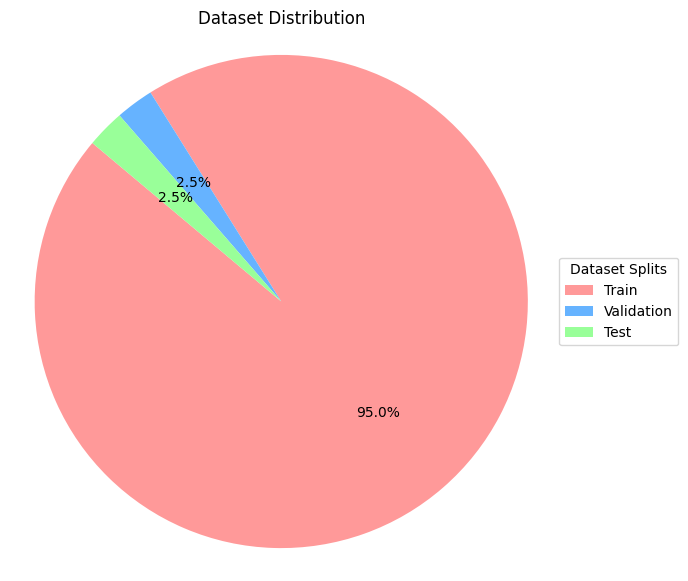

In [ ]:
import matplotlib.pyplot as plt

# Dữ liệu số lượng mẫu trong mỗi tập
dataset_counts = {
    'Train': 681794,
    'Validation': 17878,
    'Test': 17920
}

# Labels và values
labels = list(dataset_counts.keys())
sizes = list(dataset_counts.values())

# Màu sắc cho từng phần
colors = ['#ff9999','#66b3ff','#99ff99']  # Tùy chọn màu

# Vẽ biểu đồ hình tròn
plt.figure(figsize=(7, 7))
plt.pie(sizes, autopct='%1.1f%%', startangle=140, colors=colors)
plt.axis('equal')  # Đảm bảo hình tròn không bị méo
plt.title('Dataset Distribution')

# Thêm ký hiệu (legend) với các màu tương ứng
plt.legend(labels, title="Dataset Splits", loc="center left", bbox_to_anchor=(1, 0, 0.5, 1))

plt.show()


## 3.2. Chia lại Source và Target

In [ ]:
def split_source_target(dataset):
    """
    Tách cột `text` thành `source` và `target` dựa vào số lượng dòng.
    """
    num_rows = len(dataset)
    mid_index = num_rows // 2  # Chia đôi dataset

    # Chia dữ liệu thành hai phần
    source_data = dataset.select(range(0, mid_index))  # Nửa trên: source
    target_data = dataset.select(range(mid_index, num_rows))  # Nửa dưới: target

    # Tạo dataset mới với cột `source` và `target`
    new_dataset = Dataset.from_dict({
        "source": source_data["text"],
        "target": target_data["text"]
    })
    return new_dataset

# Áp dụng cho các tập train, validation, test
ds['train'] = split_source_target(ds['train'])
ds['validation'] = split_source_target(ds['validation'])
ds['test'] = split_source_target(ds['test'])

# Kiểm tra kết quả
print(ds['train'][0])  # Xem cặp source-target đầu tiên
print(ds['train'][-1])  # Xem cặp source-target cuối cùng


{'source': 'To evaluate clinical, subclinical symptoms of patients with otitis media with effusion and V.a at otorhinolaryngology department – Thai Nguyen national hospital', 'target': 'Nghiên cứu đặc điểm lâm sàng, cận lâm sàng bệnh nhân viêm tai ứ dịch trên viêm V.A tại Khoa Tai mũi họng - Bệnh viện Trung ương Thái Nguyên'}
{'source': 'When you begin catastrophising in the lead-up to an attack, write down the thoughts that are worrying you, then throw the page away.', 'target': 'Khi bạn bắt đầu trầm trọng hoá vấn đề dẫn đến cơn hoảng loạn, hãy viết ra những suy nghĩ khiến bạn lo lắng, sau đó vứt bỏ trang giấy đi.'}


In [ ]:
print(f"Train size: {len(ds['train'])}")
print(f"Validation size: {len(ds['validation'])}")
print(f"Test size: {len(ds['test'])}")

Train size: 340897
Validation size: 8939
Test size: 8960


## 3.3. Kiểm tra cấu trúc dataset sau khi chia

In [ ]:
print(ds)

DatasetDict({
    train: Dataset({
        features: ['source', 'target'],
        num_rows: 340897
    })
    validation: Dataset({
        features: ['source', 'target'],
        num_rows: 8939
    })
    test: Dataset({
        features: ['source', 'target'],
        num_rows: 8960
    })
})


## 3.4. Tiến hành Cleaning dữ liệu

In [ ]:
# Step 1: Cleaning the dataset
def clean_text(text):
    import re
    text = text.strip()  # Giữ nguyên chữ hoa và chữ thường
    text = re.sub(r"[\uf0b1\uf063\uf05d\xad\uf062\uf76a\uf0b0\uf03c\uf02d\uf067\ufeff\uf0ae\uf0b3\uf044\uf0a3\uf020\uf061\uf0b4\uf06d\uf026\uf05b\uf0a2\uf0d2\x02\u200e\u200b\ufeff\uf067\uf02d]", "", text)
    text = re.sub(r"\s+", " ", text)  # Loại bỏ khoảng trắng thừa
    return text

# Áp dụng cleaning cho source và target
ds['train'] = ds['train'].map(lambda x: {'source': clean_text(x['source']), 'target': clean_text(x['target'])})
ds['validation'] = ds['validation'].map(lambda x: {'source': clean_text(x['source']), 'target': clean_text(x['target'])})
ds['test'] = ds['test'].map(lambda x: {'source': clean_text(x['source']), 'target': clean_text(x['target'])})


Map:   0%|          | 0/340897 [00:00<?, ? examples/s]

Map:   0%|          | 0/8939 [00:00<?, ? examples/s]

Map:   0%|          | 0/8960 [00:00<?, ? examples/s]

### Example

In [ ]:
import re

# Bước 1: Giữ lại ký tự PUA trong cleaning (nếu bạn không muốn loại bỏ chúng)
def clean_text(text):
    import re
    text = text.strip()  # Giữ nguyên chữ hoa và chữ thường
    text = re.sub(r"[\uf0b1\uf063\uf05d\xad\uf062\uf76a\uf0b0\uf03c\uf02d\uf067\ufeff\uf0ae\uf0b3\uf044\uf0a3\uf020\uf061\uf0b4\uf06d\uf026\uf05b\uf0a2\uf0d2\x02\u200e\u200b\ufeff\uf067\uf02d]", "", text)
    text = re.sub(r"\s+", " ", text)  # Loại bỏ khoảng trắng thừa
    return text

# Bước 2: Khi bạn hiển thị văn bản, đảm bảo sử dụng font hỗ trợ PUA (FontAwesome)
text = "\uf062\uf0a3\uf0b1\uf063\uf05d\xad\uf0b0\uf03c\uf02d\uf067\ufeff\uf0ae\uf0b3\uf044\uf020\uf061\uf0b4\uf06d\uf026\uf05b\uf0a2\uf0d2\x02\u200e\u200b\ufeff\uf067\uf02d ancaa"
cleaned_text = clean_text(text)

# Để hiển thị, bạn cần sử dụng font hỗ trợ PUA (ví dụ trong Jupyter Notebook hoặc ứng dụng GUI)
print(cleaned_text)  # Kết quả vẫn giữ lại các ký tự PUA


 ancaa


## 3.5. Test thử hàm (Đọc thêm)

In [ ]:
text = "Hello! Đây là 1 câu #test Cancil-a, ễ. a : 5%mail@.com, 2+5=3))"
re.sub(r"[^\w\s.,!?@áàảãạăắằẳẵặâấầẩẫậéèẻẽẹêếềểễệíìỉĩịóòỏõọôốồổỗộơớờởỡợúùủũụưứừửữựýỳỷỹỵđ%-+=]", "", text)
# Kết quả: "Hello! Đây là 1 câu test "
print(text)


Hello! Đây là 1 câu #test Cancil-a, ễ. a : 5%mail@.com, 2+5=3))


In [ ]:
# Nguyên tắc bất biến 1
# Kí hiệu \s+ và " " và không đặt \s+ trong dấu ngoặc [] và không có ^: Loại bỏ khoảng trắng thừa và giữ lại duy nhất 1 khoảng trắng
text = "Hello     World+!  "
re.sub(r"\s+", " ", text)
# Kết quả: "Hello World! "


'Hello World+! '

In [ ]:
# Kí hiệu \s+ và " " và ^: =>Vi phạm nguyên tắc bất biến 1
text = "Hello     World+-*/!  "
re.sub(r"^\s+-*", " ", text)
# Kết quả: "Hello World! "

'Hello     World+-*/!  '

In [ ]:
# Nguyên tắc bất biến 2
# Kí hiệu \s và "" và không đặt \s trong dấu ngoặc [] và không có ^: Loại bỏ tất cả khoảng trắng thừa
# TH \s\+-* và "" không được
text = "Hello     World+-*/!  "
re.sub(r"\s-*", "", text)
# Kết quả: "Hello World! "


'HelloWorld+-*/!'

In [ ]:
# Kí hiệu \s và và ^: =>Vi phạm nguyên tắc bất biến 2
text = "Hello     World+-*/!  "
re.sub(r"^\s-*", "", text)
# Kết quả: "Hello World! "


'Hello     World+-*/!  '

In [ ]:
# Kí hiệu \s và " ": => Vi phạm nguyên tắc bất biến 2
text = "Hello     World+-*/!  "
re.sub(r"\s-*", " ", text)
# Kết quả: "Hello World! "


'Hello     World+-*/!  '

In [ ]:
# nguyên tắc bất biến 3
# [] và " ": Giữ lại khoảng trắng mặc định kèm khoảng trắng của kí tự bỏ đi, Loại bỏ các kí tự nằm trong [] ngoài khoảng trắng
# [] và "": xóa đi khoảng trắng mặc định, Không kèm khoảng trắng của kí tự bị bỏ đi, Loại bỏ các kí tự nằm trong [] ngoài khoảng trắng
# [] và <space> hoặc \s và " ": Giữ lại khoảng trắng mặc định kèm khoảng trắng của kí tự bị bỏ đi, Loại bỏ các kí tự nằm trong [] ngoài khoảng trắng
# [] và <space> hoặc \s và "": Xóa bỏ khoảng trắng mặc định kèm khoảng trắng của kí tự bỏ đi, Loại bỏ các kí tự nằm trong []
# \s+ nằm trong dấu ngoặc [] => vi phạm nguyên tắc bất biến 1
text = "Hello! Đây là 1 câu #test Cancil-a,    ễ. a : 5%mail@.com, 2+5=3 [\))\\*:012 PQKT áàảãạăắằẳẵặâấầẩẫậéèẻẽẹêếềểễệíìỉĩịóòỏõọôốồổỗộơớờởỡợúùủũụưứừửữựýỳỷỹỵđ"
text = re.sub(r"[ +.,!?]", " ", text)
# text = re.sub(r"\s+", " ", text)
print(text)

Hello  Đây là 1 câu #test Cancil-a     ễ  a : 5%mail@ com  2 5=3 [\))\*:012 PQKT áàảãạăắằẳẵặâấầẩẫậéèẻẽẹêếềểễệíìỉĩịóòỏõọôốồổỗộơớờởỡợúùủũụưứừửữựýỳỷỹỵđ


In [ ]:
# \s+ và " " : => vi phạm nguyên tắc bất biến 1 và 2
text = "Hello! Đây là 1 câu #test Cancil-a, ễ.    a : 5%mail@.com, 2+5=3 \))"
text=re.sub(r"[\s+-:#]", " ", text)
print(text)

Hello! Đây là   câu  test Cancil a  ễ     a    %mail@ com     =  \))


---------------------

In [ ]:
# Nếu muốn kết hợp nguyên tắc bất biến 1 và 3, ta cần tách ra 2 đoạn code riêng, kết hợp nguyên tắc bất biến 3 và 1
text = "Hello! Đây là 1 câu #test Cancil-a, ễ.    a : 5%mail@.com, 2+5=3 \))"
text=re.sub(r"[\s+-:]", " ", text)
text=re.sub(r"\s+"," ", text)
print(text)

Hello! Đây là câu #test Cancil a ễ a %mail@ com = \))


In [ ]:
# Nguyên tắc bất biến 4:
# Kí hiệu \w: tất cả các chữ cái và số
text = "Hello! Đây là 1 câu #test Cancil-a,    ễ. a : 5%mail@.com, 2+5=3 [\))\\*:012 PQKT"
# text = re.sub(r"[^\w\s.,!?áàảãạăắằẳẵặâấầẩẫậéèẻẽẹêếềểễệíìỉĩịóòỏõọôốồổỗộơớờởỡợúùủũụưứừửữựýỳỷỹỵđ]", "", text)
text = re.sub(r"[\w:]", "", text)
# text = re.sub(r"\s+", " ", text)  # Loại bỏ khoảng trắng thừa
print(text)

!     # -,    .   %@., += [\))\* 


In [ ]:
# Nguyên tắc bất biến 5:
# ^ và " ": Giữ lại khoảng trắng mặc định kèm khoảng trắng của kí tự bỏ đi, giữ lại các kí tự nằm sau dấu mũ
# ^ và "": Giữ lại khoảng trắng mặc định, Không kèm khoảng trắng của kí tự bị bỏ đi, giữ lại các kí tự nằm sau dấu mũ
# ^\s hoặc ^<space> và " ": Giữ lại khoảng trắng mặc định kèm khoảng trắng của kí tự bỏ đi, giữ lại các kí tự nằm sau dấu mũ
# ^\s hoặc ^<space> và "": Giữ lại khoảng trắng mặc định không kèm khoảng trắng của kí tự bỏ đi, giữ lại các kí tự nằm sau dấu mũ
# Kí hiệu ^ và []: Giữ lại tất cả các kí tự nằm trong [] và sau dấu ^
text = "Hello! Đây là 1 câu test Cancil-a,    ễ. a : 5%mail@.com, 2+5=3 [\))\\*:012 PQKT áàảãạăắằẳẵặâấầẩẫậéèẻẽẹêếềểễệíìỉĩịóòỏõọôốồổỗộơớờởỡợúùủũụưứừửữựýỳỷỹỵđ"
text = re.sub(r"[^ \w+.,?]", " ", text)
# text = re.sub(r"\s+", " ", text)
print(text)

Hello  Đây là 1 câu test Cancil a,    ễ. a   5 mail .com, 2+5 3        012 PQKT áàảãạăắằẳẵặâấầẩẫậéèẻẽẹêếềểễệíìỉĩịóòỏõọôốồổỗộơớờởỡợúùủũụưứừửữựýỳỷỹỵđ


In [ ]:
text = "Hello! Đây là 1 câu #test Cancil-a,    ễ. a : 5%mail@.com, 2+5=3 [\))\\*:012 PQKT"
# text = re.sub(r"[^\w\s.,!?áàảãạăắằẳẵặâấầẩẫậéèẻẽẹêếềểễệíìỉĩịóòỏõọôốồổỗộơớờởỡợúùủũụưứừửữựýỳỷỹỵđ]", "", text)
text = re.sub(r"[^\w\s.,!?áàảãạăắằẳẵặâấầẩẫậéèẻẽẹêếềểễệíìỉĩịóòỏõọôốồổỗộơớờởỡợúùủũụưứừửữựýỳỷỹỵđ]", "", text)
text = re.sub(r"\s+", " ", text)  # Loại bỏ khoảng trắng thừa
print(text)

Hello! Đây là 1 câu test Cancila, ễ. a 5mail.com, 253 012 PQKT


In [ ]:
# Loại bỏ dấu \ và [
text = "Hello! Đây là 1 câu #test Cancil-a, ễ. a : 5%mail@.com, 2+5=3!!! [\))"
text = re.sub(r"[\[\\.,!?áàảãạăắằẳẵặâấầẩẫậéèẻẽẹêếềểễệíìỉĩịóòỏõọôốồổỗộơớờởỡợúùủũụưứừửữựýỳỷỹỵđ]", "",text)
print(text)

Hello Đy l 1 cu #test Cancil-a  a : 5%mail@com 2+5=3 ))


In [ ]:
# Loại bỏ dấu \
text = "Hello! Đây là 1 câu #test Cancil-a, ễ. a : 5%mail@.com, 2+5=3!!! [\\\\\\,,,\,\))"
text = re.sub(r"[\\.,!?áàảãạăắằẳẵặâấầẩẫậéèẻẽẹêếềểễệíìỉĩịóòỏõọôốồổỗộơớờởỡợúùủũụưứừửữựýỳỷỹỵđ]", "",text)
print(text)

Hello Đy l 1 cu #test Cancil-a  a : 5%mail@com 2+5=3 [))


In [ ]:
text = "Hello! Đây là 1 câu #test Cancil-a, ễ.    a : 5%mail@.com, 2+5=3!!! [\\\\\\,,,\,\))"
text = re.sub(r"[\s+\\.,!?áàảãạăắằẳẵặâấầẩẫậéèẻẽẹêếềểễệíìỉĩịóòỏõọôốồổỗộơớờởỡợúùủũụưứừửữựýỳỷỹỵđ]", "",text)
print(text)

HelloĐyl1cu#testCancil-aa:5%mail@com25=3[))


# 4. Thống kê dữ liệu

## 4.1. Kiểm tra phân phối độ dài câu cho tập train

### 4.1.1. Nhìn nhanh

#### A. Trước Cleaning

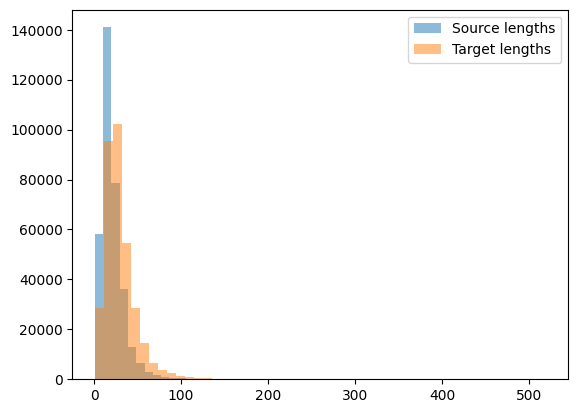

In [ ]:
def get_length_distribution(dataset, column):
    return [len(sentence.split()) for sentence in dataset[column]]

source_lengths = get_length_distribution(ds['train'], 'source')
target_lengths = get_length_distribution(ds['train'], 'target')

import matplotlib.pyplot as plt
plt.hist(source_lengths, bins=50, alpha=0.5, label='Source lengths')
plt.hist(target_lengths, bins=50, alpha=0.5, label='Target lengths')
plt.legend()
plt.show()


#### B. Sau Cleaning

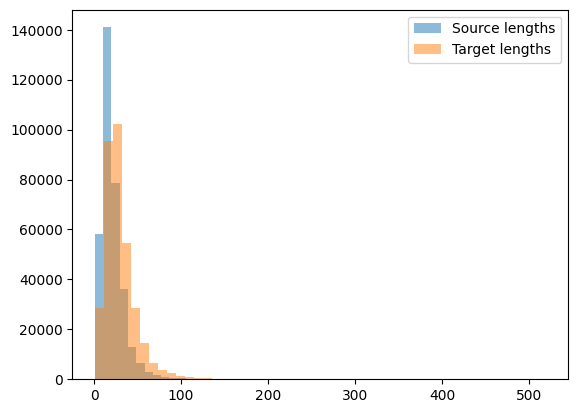

In [ ]:
def get_length_distribution(dataset, column):
    return [len(sentence.split()) for sentence in dataset[column]]

source_lengths = get_length_distribution(ds['train'], 'source')
target_lengths = get_length_distribution(ds['train'], 'target')

import matplotlib.pyplot as plt
plt.hist(source_lengths, bins=50, alpha=0.5, label='Source lengths')
plt.hist(target_lengths, bins=50, alpha=0.5, label='Target lengths')
plt.legend()
plt.show()


### 4.1.2. Viết lại tách ra 2 hình nhìn cho rõ hơn

#### A. Trước Cleaning

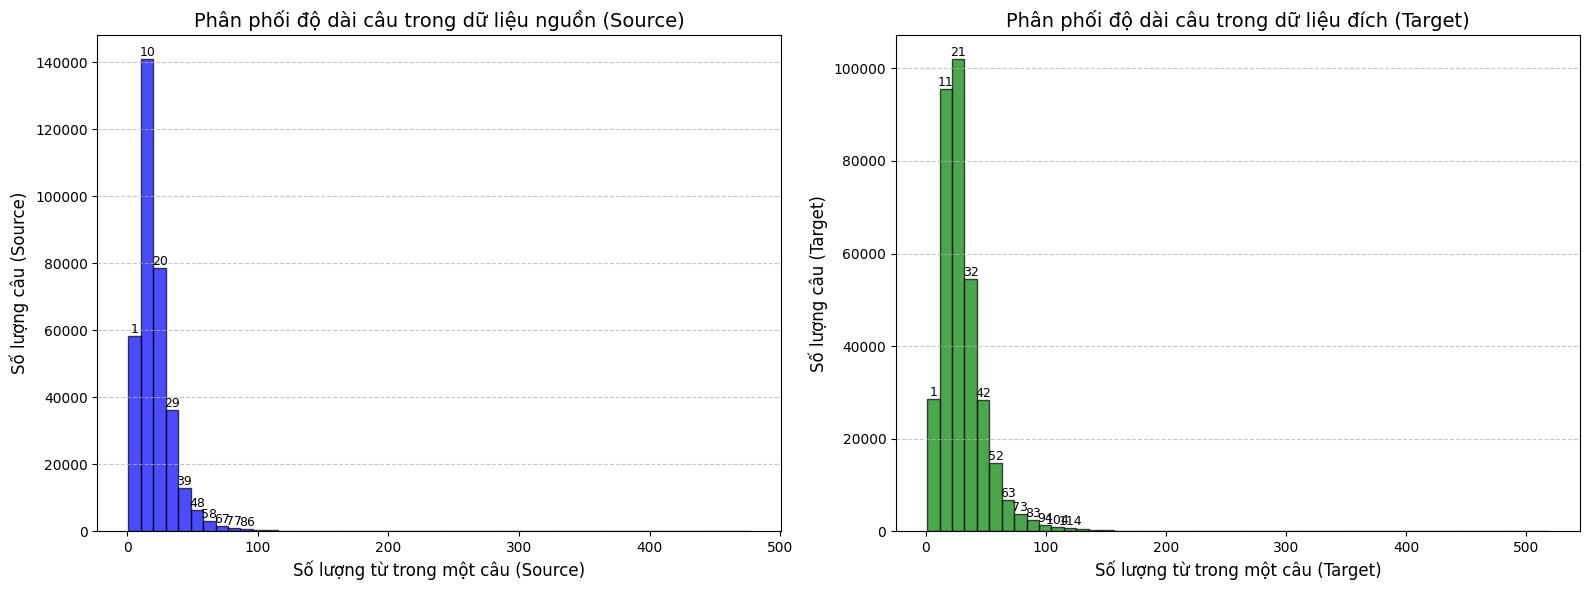

In [ ]:
import matplotlib.pyplot as plt

def get_length_distribution(dataset, column):
    # Trả về danh sách số lượng từ trong mỗi câu
    return [len(sentence.split()) for sentence in dataset[column]]

# Lấy dữ liệu độ dài câu
source_lengths = get_length_distribution(ds['train'], 'source')
target_lengths = get_length_distribution(ds['train'], 'target')

# Hàm để vẽ histogram
def plot_histogram_with_word_counts(ax, data, title, xlabel, ylabel, color):
    # Vẽ histogram và lấy giá trị
    counts, bins, patches = ax.hist(data, bins=50, alpha=0.7, color=color, edgecolor='black')

    # Thêm số lượng từ lên trên đỉnh mỗi cột
    for i in range(len(patches)):
        bin_center = (bins[i] + bins[i + 1]) / 2  # Vị trí giữa của cột
        word_count = int(bins[i])  # Lấy số từ (giá trị trục hoành)

        if counts[i] > 500:  # Hiển thị nếu số câu trong cột > 0
            ax.text(bin_center, counts[i], word_count, ha='center', va='bottom', fontsize=9, color='black')

    # Thêm nhãn và tiêu đề
    ax.set_xlabel(xlabel, fontsize=12)
    ax.set_ylabel(ylabel, fontsize=12)
    ax.set_title(title, fontsize=14)
    ax.grid(axis='y', linestyle='--', alpha=0.7)

# Tạo bố cục 1 hàng 2 cột
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Vẽ histogram cho source_lengths
plot_histogram_with_word_counts(
    axes[0],
    source_lengths,
    title='Phân phối độ dài câu trong dữ liệu nguồn (Source)',
    xlabel='Số lượng từ trong một câu (Source)',
    ylabel='Số lượng câu (Source)',
    color='blue'
)

# Vẽ histogram cho target_lengths
plot_histogram_with_word_counts(
    axes[1],
    target_lengths,
    title='Phân phối độ dài câu trong dữ liệu đích (Target)',
    xlabel='Số lượng từ trong một câu (Target)',
    ylabel='Số lượng câu (Target)',
    color='green'
)

# Hiển thị biểu đồ
plt.tight_layout()
plt.show()


#### B. Sau Cleaning

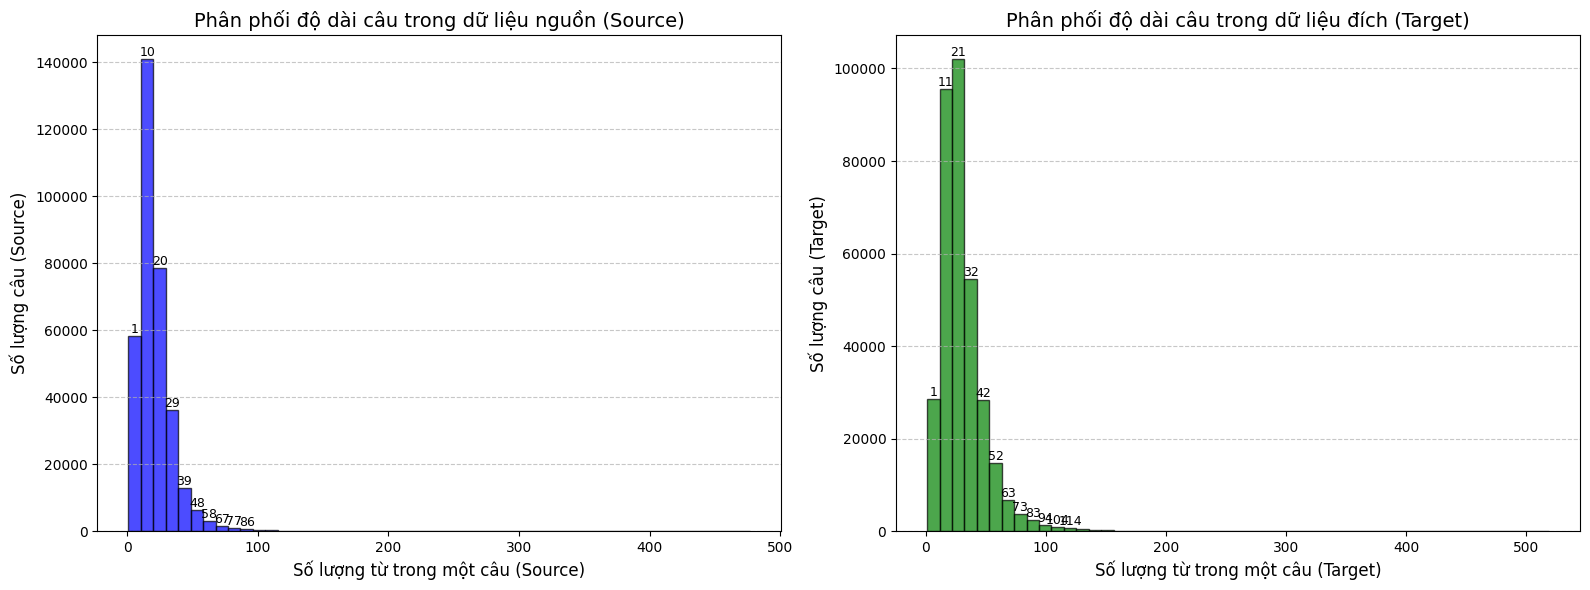

In [ ]:
import matplotlib.pyplot as plt

def get_length_distribution(dataset, column):
    # Trả về danh sách số lượng từ trong mỗi câu
    return [len(sentence.split()) for sentence in dataset[column]]

# Lấy dữ liệu độ dài câu
source_lengths = get_length_distribution(ds['train'], 'source')
target_lengths = get_length_distribution(ds['train'], 'target')

# Hàm để vẽ histogram
def plot_histogram_with_word_counts(ax, data, title, xlabel, ylabel, color):
    # Vẽ histogram và lấy giá trị
    counts, bins, patches = ax.hist(data, bins=50, alpha=0.7, color=color, edgecolor='black')

    # Thêm số lượng từ lên trên đỉnh mỗi cột
    for i in range(len(patches)):
        bin_center = (bins[i] + bins[i + 1]) / 2  # Vị trí giữa của cột
        word_count = int(bins[i])  # Lấy số từ (giá trị trục hoành)

        if counts[i] > 500:  # Hiển thị nếu số câu trong cột > 0
            ax.text(bin_center, counts[i], word_count, ha='center', va='bottom', fontsize=9, color='black')

    # Thêm nhãn và tiêu đề
    ax.set_xlabel(xlabel, fontsize=12)
    ax.set_ylabel(ylabel, fontsize=12)
    ax.set_title(title, fontsize=14)
    ax.grid(axis='y', linestyle='--', alpha=0.7)

# Tạo bố cục 1 hàng 2 cột
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Vẽ histogram cho source_lengths
plot_histogram_with_word_counts(
    axes[0],
    source_lengths,
    title='Phân phối độ dài câu trong dữ liệu nguồn (Source)',
    xlabel='Số lượng từ trong một câu (Source)',
    ylabel='Số lượng câu (Source)',
    color='blue'
)

# Vẽ histogram cho target_lengths
plot_histogram_with_word_counts(
    axes[1],
    target_lengths,
    title='Phân phối độ dài câu trong dữ liệu đích (Target)',
    xlabel='Số lượng từ trong một câu (Target)',
    ylabel='Số lượng câu (Target)',
    color='green'
)

# Hiển thị biểu đồ
plt.tight_layout()
plt.show()


### 4.1.3. Tính tổng số từ trong target và trong source

#### A. Trước Cleaning

Source:
Tổng số câu: 340897
Tổng số từ: 7261111

Target:
Tổng số câu: 340897
Tổng số từ: 10293803

Source và Target:
Tổng số câu: 681794
Tổng số từ: 17554914


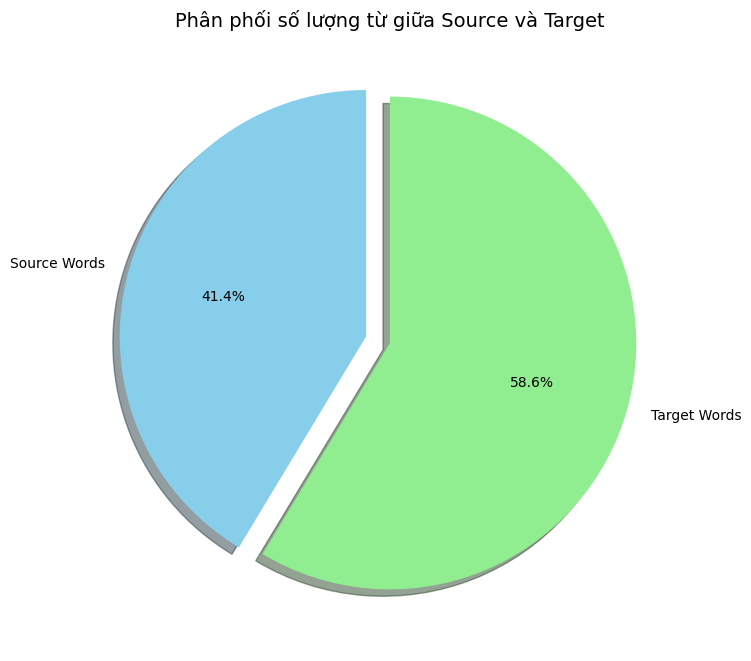

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Lấy dữ liệu độ dài câu
source_lengths = get_length_distribution(ds['train'], 'source')
target_lengths = get_length_distribution(ds['train'], 'target')

# Tính tổng số câu và tổng số từ cho source và target
source_total_sentences = len(source_lengths)  # Tổng số câu của source
target_total_sentences = len(target_lengths)  # Tổng số câu của target

source_total_words = sum(source_lengths)  # Tổng số từ của source
target_total_words = sum(target_lengths)  # Tổng số từ của target

# In ra kết quả
print("Source:")
print(f"Tổng số câu: {source_total_sentences}")
print(f"Tổng số từ: {source_total_words}")
print("\nTarget:")
print(f"Tổng số câu: {target_total_sentences}")
print(f"Tổng số từ: {target_total_words}")
print("\nSource và Target:")
print(f"Tổng số câu: {source_total_sentences + target_total_sentences}")
print(f"Tổng số từ: {source_total_words + target_total_words}")

# Vẽ đồ thị hình tròn biểu diễn số lượng từ trong source và target
labels = ['Source Words', 'Target Words']
sizes = [source_total_words, target_total_words]  # Số lượng từ của source và target
colors = ['skyblue', 'lightgreen']  # Màu sắc cho từng phần
explode = (0.1, 0)  # Phần Source tách ra một chút để làm nổi bật

plt.figure(figsize=(8, 8))  # Kích thước đồ thị
plt.pie(
    sizes,
    labels=labels,
    autopct='%1.1f%%',  # Hiển thị tỷ lệ phần trăm
    startangle=90,
    colors=colors,
    explode=explode,
    shadow=True
)
plt.title('Phân phối số lượng từ giữa Source và Target', fontsize=14)
plt.show()


#### B. Sau Cleaning

Source:
Tổng số câu: 340897
Tổng số từ: 7260961

Target:
Tổng số câu: 340897
Tổng số từ: 10293476

Source và Target:
Tổng số câu: 681794
Tổng số từ: 17554437


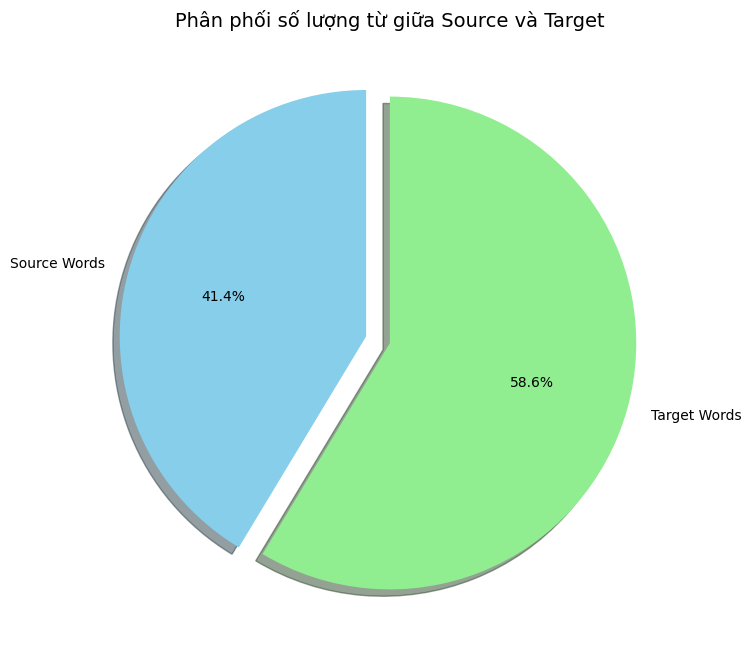

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Lấy dữ liệu độ dài câu
source_lengths = get_length_distribution(ds['train'], 'source')
target_lengths = get_length_distribution(ds['train'], 'target')

# Tính tổng số câu và tổng số từ cho source và target
source_total_sentences = len(source_lengths)  # Tổng số câu của source
target_total_sentences = len(target_lengths)  # Tổng số câu của target

source_total_words = sum(source_lengths)  # Tổng số từ của source
target_total_words = sum(target_lengths)  # Tổng số từ của target

# In ra kết quả
print("Source:")
print(f"Tổng số câu: {source_total_sentences}")
print(f"Tổng số từ: {source_total_words}")
print("\nTarget:")
print(f"Tổng số câu: {target_total_sentences}")
print(f"Tổng số từ: {target_total_words}")
print("\nSource và Target:")
print(f"Tổng số câu: {source_total_sentences + target_total_sentences}")
print(f"Tổng số từ: {source_total_words + target_total_words}")

# Vẽ đồ thị hình tròn biểu diễn số lượng từ trong source và target
labels = ['Source Words', 'Target Words']
sizes = [source_total_words, target_total_words]  # Số lượng từ của source và target
colors = ['skyblue', 'lightgreen']  # Màu sắc cho từng phần
explode = (0.1, 0)  # Phần Source tách ra một chút để làm nổi bật

plt.figure(figsize=(8, 8))  # Kích thước đồ thị
plt.pie(
    sizes,
    labels=labels,
    autopct='%1.1f%%',  # Hiển thị tỷ lệ phần trăm
    startangle=90,
    colors=colors,
    explode=explode,
    shadow=True
)
plt.title('Phân phối số lượng từ giữa Source và Target', fontsize=14)
plt.show()


## 4.2. Xây dựng Vocabulary sử dụng cho tập train và độ phủ từ

#### A. Trước Cleaning

In [ ]:
from collections import Counter
from datasets import Dataset, DatasetDict

# Hàm lấy vocab cho dataset
def get_vocab(dataset, column):
    vocab = Counter()
    for sentence in dataset[column]:
        vocab.update(sentence.split())
    return vocab

# Lấy từ vựng cho cột 'source' và 'target' cho tập train
source_vocab_train = get_vocab(ds['train'], 'source')
target_vocab_train = get_vocab(ds['train'], 'target')
# Lấy từ vựng cho cột 'source' và 'target' cho tập validation
source_vocab_validation = get_vocab(ds['validation'], 'source')
target_vocab_validation = get_vocab(ds['validation'], 'target')
# Lấy từ vựng cho cột 'source' và 'target' cho tập test
source_vocab_test = get_vocab(ds['test'], 'source')
target_vocab_test = get_vocab(ds['test'], 'target')


# Chuyển Counter thành danh sách các từ (có thể là từ phổ biến nhất hoặc tất cả các từ)
# train
source_vocab_list_train = list(source_vocab_train.keys())  # Lấy tất cả các từ duy nhất
target_vocab_list_train = list(target_vocab_train.keys())  # Lấy tất cả các từ duy nhất
# validation
source_vocab_list_validation = list(source_vocab_validation.keys())  # Lấy tất cả các từ duy nhất
target_vocab_list_validation = list(target_vocab_validation.keys())  # Lấy tất cả các từ duy nhất
# test
source_vocab_list_test = list(source_vocab_test.keys())  # Lấy tất cả các từ duy nhất
target_vocab_list_test = list(target_vocab_test.keys())  # Lấy tất cả các từ duy nhất
# Tạo dataset mới với source_vocab và target_vocab
ds_new_train = DatasetDict({
    'source_vocab_train': Dataset.from_dict({'tokens': source_vocab_list_train}),
    'target_vocab_train': Dataset.from_dict({'tokens': target_vocab_list_train})
})
ds_new_validation = DatasetDict({
    'source_vocab_validation': Dataset.from_dict({'tokens': source_vocab_list_validation}),
    'target_vocab_validation': Dataset.from_dict({'tokens': target_vocab_list_validation})
})
ds_new_test = DatasetDict({
    'source_vocab_test': Dataset.from_dict({'tokens': source_vocab_list_test}),
    'target_vocab_test': Dataset.from_dict({'tokens': target_vocab_list_test})
})
# In cấu trúc bộ vocabulary mới
# Tập train
print("Tập train:")
print("Cấu trúc vocabulary mới là:\n", ds_new_train)
# In ra ví dụ
print("Ví dụ in ra từ đầu tiên:")
print("source_vocab", ds_new_train['source_vocab_train'][0])  # In ra từ đầu tiên trong source_vocab
print("target_vocab", ds_new_train['target_vocab_train'][0])  # In ra từ đầu tiên trong target_vocab
# In ra số lượng từ phổ biến
print("Most common words in source:", source_vocab_train.most_common(10))
print("Most common words in target:", target_vocab_train.most_common(10))
# Tập validation
print("Tập validation:")
print("Cấu trúc vocabulary mới là:\n", ds_new_validation)
# In ra ví dụ
print("Ví dụ in ra từ đầu tiên:")
print("source_vocab", ds_new_validation['source_vocab_validation'][0])  # In ra từ đầu tiên trong source_vocab
print("target_vocab", ds_new_validation['target_vocab_validation'][0])  # In ra từ đầu tiên trong target_vocab
# In ra số lượng từ phổ biến
print("Most common words in source:", source_vocab_validation.most_common(10))
print("Most common words in target:", target_vocab_validation.most_common(10))
# Tập test
print("Tập test:")
print("Cấu trúc vocabulary mới là:\n", ds_new_test)
# In ra ví dụ
print("Ví dụ in ra từ đầu tiên:")
print("source_vocab", ds_new_test['source_vocab_test'][0])  # In ra từ đầu tiên trong source_vocab
print("target_vocab", ds_new_test['target_vocab_test'][0])  # In ra từ đầu tiên trong target_vocab
# In ra số lượng từ phổ biến
print("Most common words in source:", source_vocab_test.most_common(10))
print("Most common words in target:", target_vocab_test.most_common(10))


Tập train:
Cấu trúc vocabulary mới là:
 DatasetDict({
    source_vocab_train: Dataset({
        features: ['tokens'],
        num_rows: 295085
    })
    target_vocab_train: Dataset({
        features: ['tokens'],
        num_rows: 188251
    })
})
Ví dụ in ra từ đầu tiên:
source_vocab {'tokens': 'To'}
target_vocab {'tokens': 'Nghiên'}
Most common words in source: [('of', 288924), ('the', 249905), ('and', 233244), ('in', 145422), ('to', 119948), ('with', 94437), ('is', 86694), ('a', 65694), ('The', 58889), ('for', 58001)]
Most common words in target: [('và', 204752), ('có', 151591), ('bệnh', 130930), ('là', 97057), ('các', 95469), ('của', 89217), ('được', 85607), ('nhân', 82585), ('trong', 77164), ('với', 69135)]
Tập validation:
Cấu trúc vocabulary mới là:
 DatasetDict({
    source_vocab_validation: Dataset({
        features: ['tokens'],
        num_rows: 30199
    })
    target_vocab_validation: Dataset({
        features: ['tokens'],
        num_rows: 18262
    })
})
Ví dụ in ra từ 

#### B. Sau Cleaning

In [ ]:
from collections import Counter
from datasets import Dataset, DatasetDict

# Hàm lấy vocab cho dataset
def get_vocab(dataset, column):
    vocab = Counter()
    for sentence in dataset[column]:
        vocab.update(sentence.split())
    return vocab

# Lấy từ vựng cho cột 'source' và 'target' cho tập train
source_vocab_train = get_vocab(ds['train'], 'source')
target_vocab_train = get_vocab(ds['train'], 'target')
# Lấy từ vựng cho cột 'source' và 'target' cho tập validation
source_vocab_validation = get_vocab(ds['validation'], 'source')
target_vocab_validation = get_vocab(ds['validation'], 'target')
# Lấy từ vựng cho cột 'source' và 'target' cho tập test
source_vocab_test = get_vocab(ds['test'], 'source')
target_vocab_test = get_vocab(ds['test'], 'target')


# Chuyển Counter thành danh sách các từ (có thể là từ phổ biến nhất hoặc tất cả các từ)
# train
source_vocab_list_train = list(source_vocab_train.keys())  # Lấy tất cả các từ duy nhất
target_vocab_list_train = list(target_vocab_train.keys())  # Lấy tất cả các từ duy nhất
# validation
source_vocab_list_validation = list(source_vocab_validation.keys())  # Lấy tất cả các từ duy nhất
target_vocab_list_validation = list(target_vocab_validation.keys())  # Lấy tất cả các từ duy nhất
# test
source_vocab_list_test = list(source_vocab_test.keys())  # Lấy tất cả các từ duy nhất
target_vocab_list_test = list(target_vocab_test.keys())  # Lấy tất cả các từ duy nhất
# Tạo dataset mới với source_vocab và target_vocab
ds_new_train = DatasetDict({
    'source_vocab_train': Dataset.from_dict({'tokens': source_vocab_list_train}),
    'target_vocab_train': Dataset.from_dict({'tokens': target_vocab_list_train})
})
ds_new_validation = DatasetDict({
    'source_vocab_validation': Dataset.from_dict({'tokens': source_vocab_list_validation}),
    'target_vocab_validation': Dataset.from_dict({'tokens': target_vocab_list_validation})
})
ds_new_test = DatasetDict({
    'source_vocab_test': Dataset.from_dict({'tokens': source_vocab_list_test}),
    'target_vocab_test': Dataset.from_dict({'tokens': target_vocab_list_test})
})
# In cấu trúc bộ vocabulary mới
# Tập train
print("Tập train:")
print("Cấu trúc vocabulary mới là:\n", ds_new_train)
# In ra ví dụ
print("Ví dụ in ra từ đầu tiên:")
print("source_vocab", ds_new_train['source_vocab_train'][0])  # In ra từ đầu tiên trong source_vocab
print("target_vocab", ds_new_train['target_vocab_train'][0])  # In ra từ đầu tiên trong target_vocab
# In ra số lượng từ phổ biến
print("Most common words in source:", source_vocab_train.most_common(10))
print("Most common words in target:", target_vocab_train.most_common(10))
# Tập validation
print("Tập validation:")
print("Cấu trúc vocabulary mới là:\n", ds_new_validation)
# In ra ví dụ
print("Ví dụ in ra từ đầu tiên:")
print("source_vocab", ds_new_validation['source_vocab_validation'][0])  # In ra từ đầu tiên trong source_vocab
print("target_vocab", ds_new_validation['target_vocab_validation'][0])  # In ra từ đầu tiên trong target_vocab
# In ra số lượng từ phổ biến
print("Most common words in source:", source_vocab_validation.most_common(10))
print("Most common words in target:", target_vocab_validation.most_common(10))
# Tập test
print("Tập test:")
print("Cấu trúc vocabulary mới là:\n", ds_new_test)
# In ra ví dụ
print("Ví dụ in ra từ đầu tiên:")
print("source_vocab", ds_new_test['source_vocab_test'][0])  # In ra từ đầu tiên trong source_vocab
print("target_vocab", ds_new_test['target_vocab_test'][0])  # In ra từ đầu tiên trong target_vocab
# In ra số lượng từ phổ biến
print("Most common words in source:", source_vocab_test.most_common(10))
print("Most common words in target:", target_vocab_test.most_common(10))


Tập train:
Cấu trúc vocabulary mới là:
 DatasetDict({
    source_vocab_train: Dataset({
        features: ['tokens'],
        num_rows: 294973
    })
    target_vocab_train: Dataset({
        features: ['tokens'],
        num_rows: 188047
    })
})
Ví dụ in ra từ đầu tiên:
source_vocab {'tokens': 'To'}
target_vocab {'tokens': 'Nghiên'}
Most common words in source: [('of', 288930), ('the', 249907), ('and', 233245), ('in', 145423), ('to', 119951), ('with', 94438), ('is', 86694), ('a', 65694), ('The', 58889), ('for', 58001)]
Most common words in target: [('và', 204752), ('có', 151592), ('bệnh', 130931), ('là', 97058), ('các', 95470), ('của', 89220), ('được', 85612), ('nhân', 82585), ('trong', 77167), ('với', 69136)]
Tập validation:
Cấu trúc vocabulary mới là:
 DatasetDict({
    source_vocab_validation: Dataset({
        features: ['tokens'],
        num_rows: 30195
    })
    target_vocab_validation: Dataset({
        features: ['tokens'],
        num_rows: 18253
    })
})
Ví dụ in ra từ 

## 4.3. Thống kê lại phân phối số từ của Vocabulary

### 4.3.1. Top 20 từ phổ biến của source và target nằm trong tập train, validation và tập test

##### A. Trước Cleaning

<ipython-input-121-81dfd80d9c85>:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=most_common_words, y=words, palette="viridis", ax=ax)
<ipython-input-121-81dfd80d9c85>:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=most_common_words, y=words, palette="viridis", ax=ax)
<ipython-input-121-81dfd80d9c85>:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=most_common_words, y=words, palette="viridis", ax=ax)
<ipython-input-121-81dfd80d9c85>:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed 

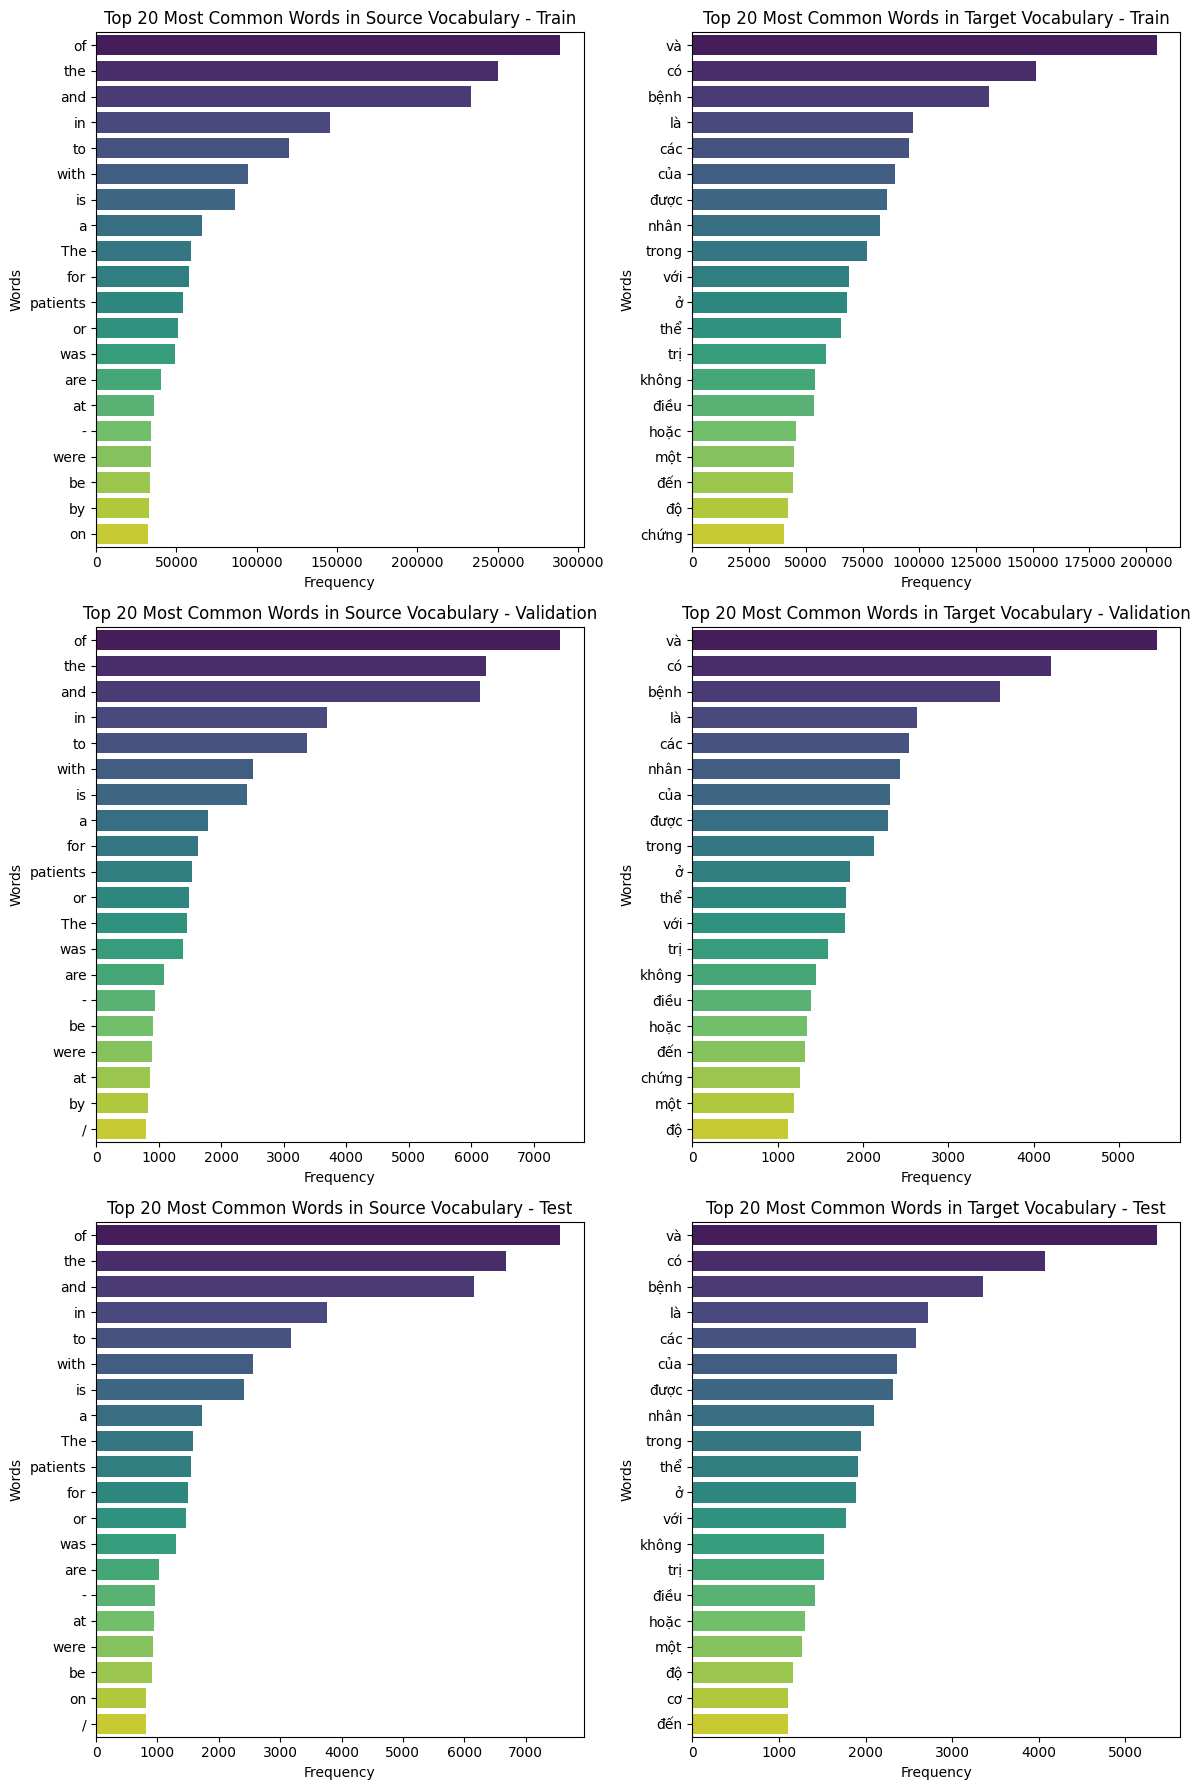

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Hàm vẽ histogram cho các tập dữ liệu
def plot_vocab_histogram(ax, vocab, dataset_name, vocab_type):
    # Lấy số lượng từ phổ biến
    most_common_words = [word[1] for word in vocab.most_common(20)]  # 20 từ phổ biến nhất
    words = [word[0] for word in vocab.most_common(20)]  # Tên các từ phổ biến nhất

    # Vẽ biểu đồ histogram
    sns.barplot(x=most_common_words, y=words, palette="viridis", ax=ax)
    ax.set_xlabel('Frequency')
    ax.set_ylabel('Words')
    ax.set_title(f'Top 20 Most Common Words in {vocab_type} Vocabulary - {dataset_name}')

# Tạo figure và axes cho 3 hàng và 2 cột
fig, axes = plt.subplots(3, 2, figsize=(12, 18))

# Vẽ histogram cho mỗi tập dữ liệu
# Tập train
plot_vocab_histogram(axes[0, 0], source_vocab_train, 'Train', 'Source')
plot_vocab_histogram(axes[0, 1], target_vocab_train, 'Train', 'Target')

# Tập validation
plot_vocab_histogram(axes[1, 0], source_vocab_validation, 'Validation', 'Source')
plot_vocab_histogram(axes[1, 1], target_vocab_validation, 'Validation', 'Target')

# Tập test
plot_vocab_histogram(axes[2, 0], source_vocab_test, 'Test', 'Source')
plot_vocab_histogram(axes[2, 1], target_vocab_test, 'Test', 'Target')

# Điều chỉnh khoảng cách giữa các biểu đồ
plt.tight_layout()
plt.show()


##### B. Sau Cleaning

<ipython-input-86-81dfd80d9c85>:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=most_common_words, y=words, palette="viridis", ax=ax)
<ipython-input-86-81dfd80d9c85>:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=most_common_words, y=words, palette="viridis", ax=ax)
<ipython-input-86-81dfd80d9c85>:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=most_common_words, y=words, palette="viridis", ax=ax)
<ipython-input-86-81dfd80d9c85>:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v

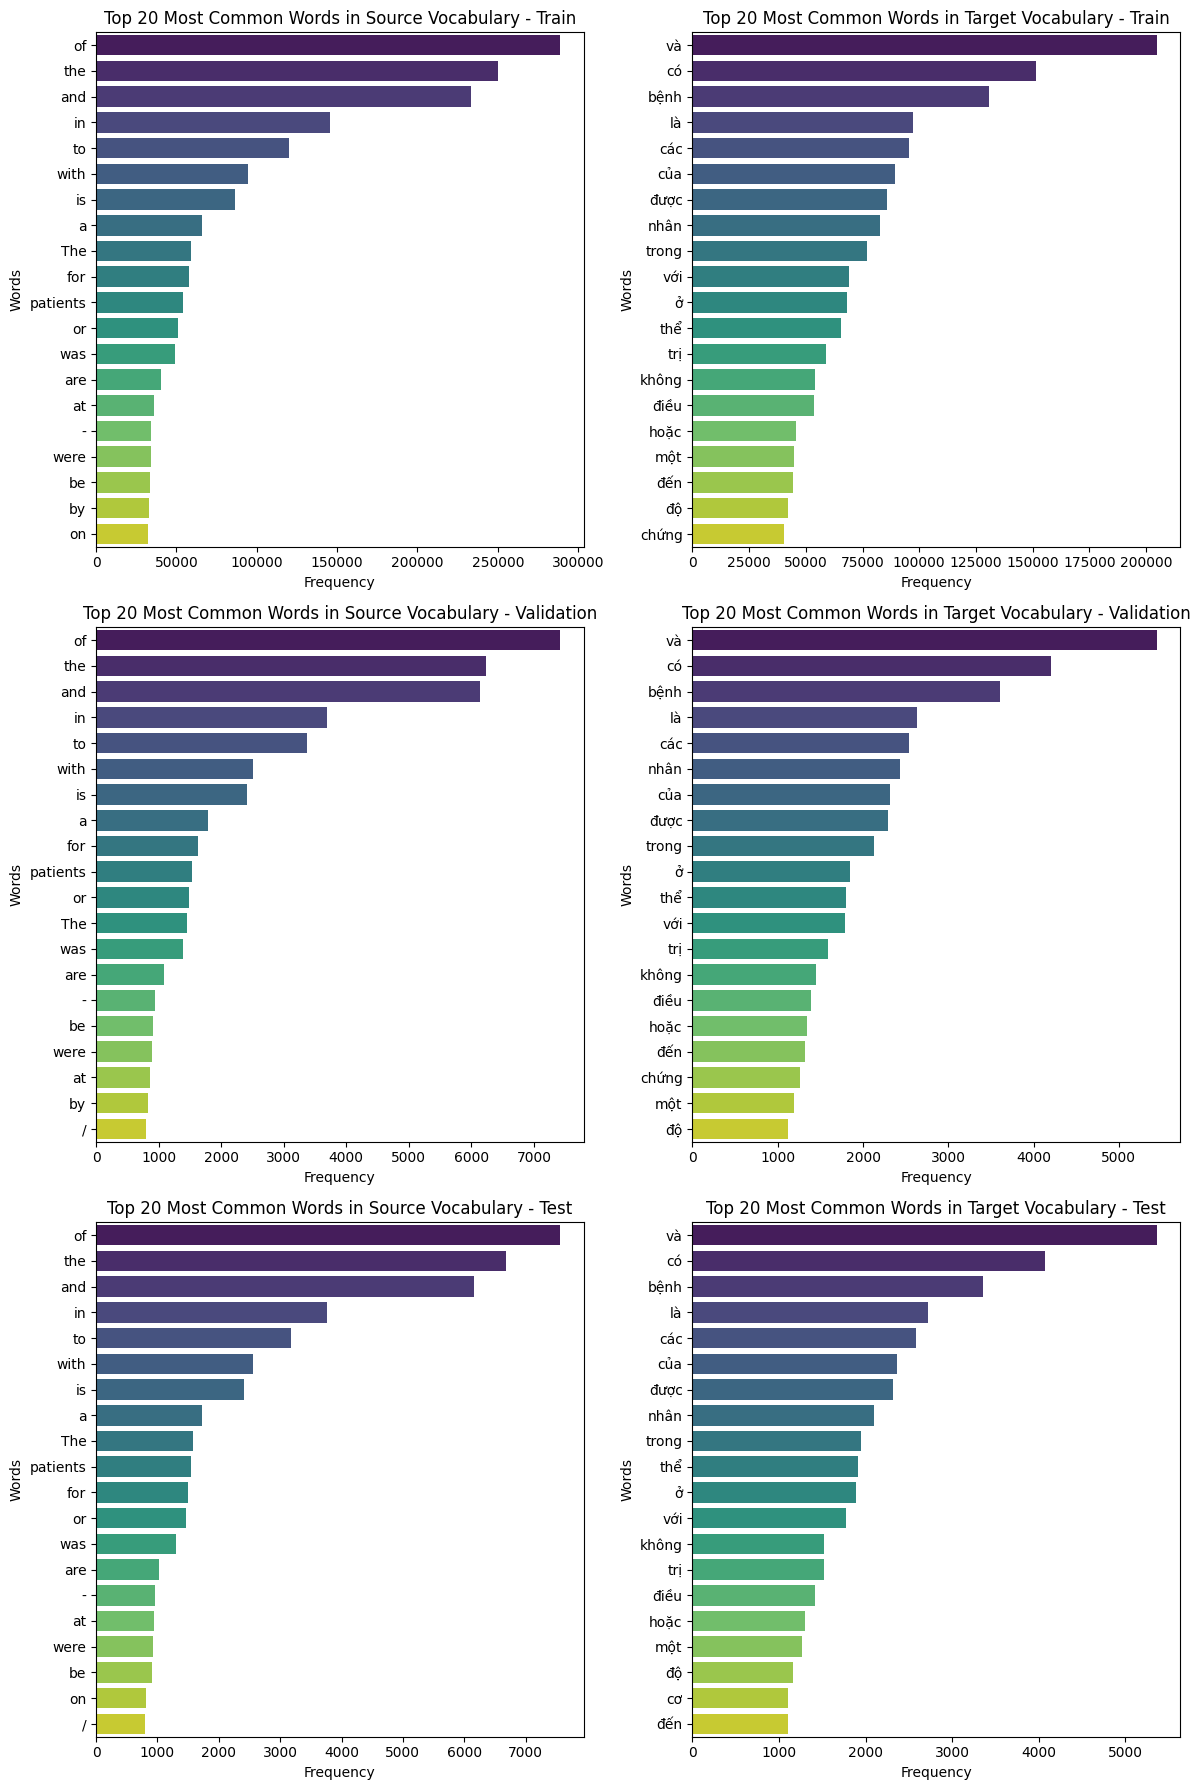

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Hàm vẽ histogram cho các tập dữ liệu
def plot_vocab_histogram(ax, vocab, dataset_name, vocab_type):
    # Lấy số lượng từ phổ biến
    most_common_words = [word[1] for word in vocab.most_common(20)]  # 20 từ phổ biến nhất
    words = [word[0] for word in vocab.most_common(20)]  # Tên các từ phổ biến nhất

    # Vẽ biểu đồ histogram
    sns.barplot(x=most_common_words, y=words, palette="viridis", ax=ax)
    ax.set_xlabel('Frequency')
    ax.set_ylabel('Words')
    ax.set_title(f'Top 20 Most Common Words in {vocab_type} Vocabulary - {dataset_name}')

# Tạo figure và axes cho 3 hàng và 2 cột
fig, axes = plt.subplots(3, 2, figsize=(12, 18))

# Vẽ histogram cho mỗi tập dữ liệu
# Tập train
plot_vocab_histogram(axes[0, 0], source_vocab_train, 'Train', 'Source')
plot_vocab_histogram(axes[0, 1], target_vocab_train, 'Train', 'Target')

# Tập validation
plot_vocab_histogram(axes[1, 0], source_vocab_validation, 'Validation', 'Source')
plot_vocab_histogram(axes[1, 1], target_vocab_validation, 'Validation', 'Target')

# Tập test
plot_vocab_histogram(axes[2, 0], source_vocab_test, 'Test', 'Source')
plot_vocab_histogram(axes[2, 1], target_vocab_test, 'Test', 'Target')

# Điều chỉnh khoảng cách giữa các biểu đồ
plt.tight_layout()
plt.show()


### 4.3.2. Top 20 từ ít phổ biến của source và target nằm trong tập train, validation và tập test

#### A. Trước cleaning

<ipython-input-122-fc11caf8ce52>:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=least_common_words, y=words, palette="viridis", ax=ax)
<ipython-input-122-fc11caf8ce52>:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=least_common_words, y=words, palette="viridis", ax=ax)
<ipython-input-122-fc11caf8ce52>:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=least_common_words, y=words, palette="viridis", ax=ax)
<ipython-input-122-fc11caf8ce52>:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be remov

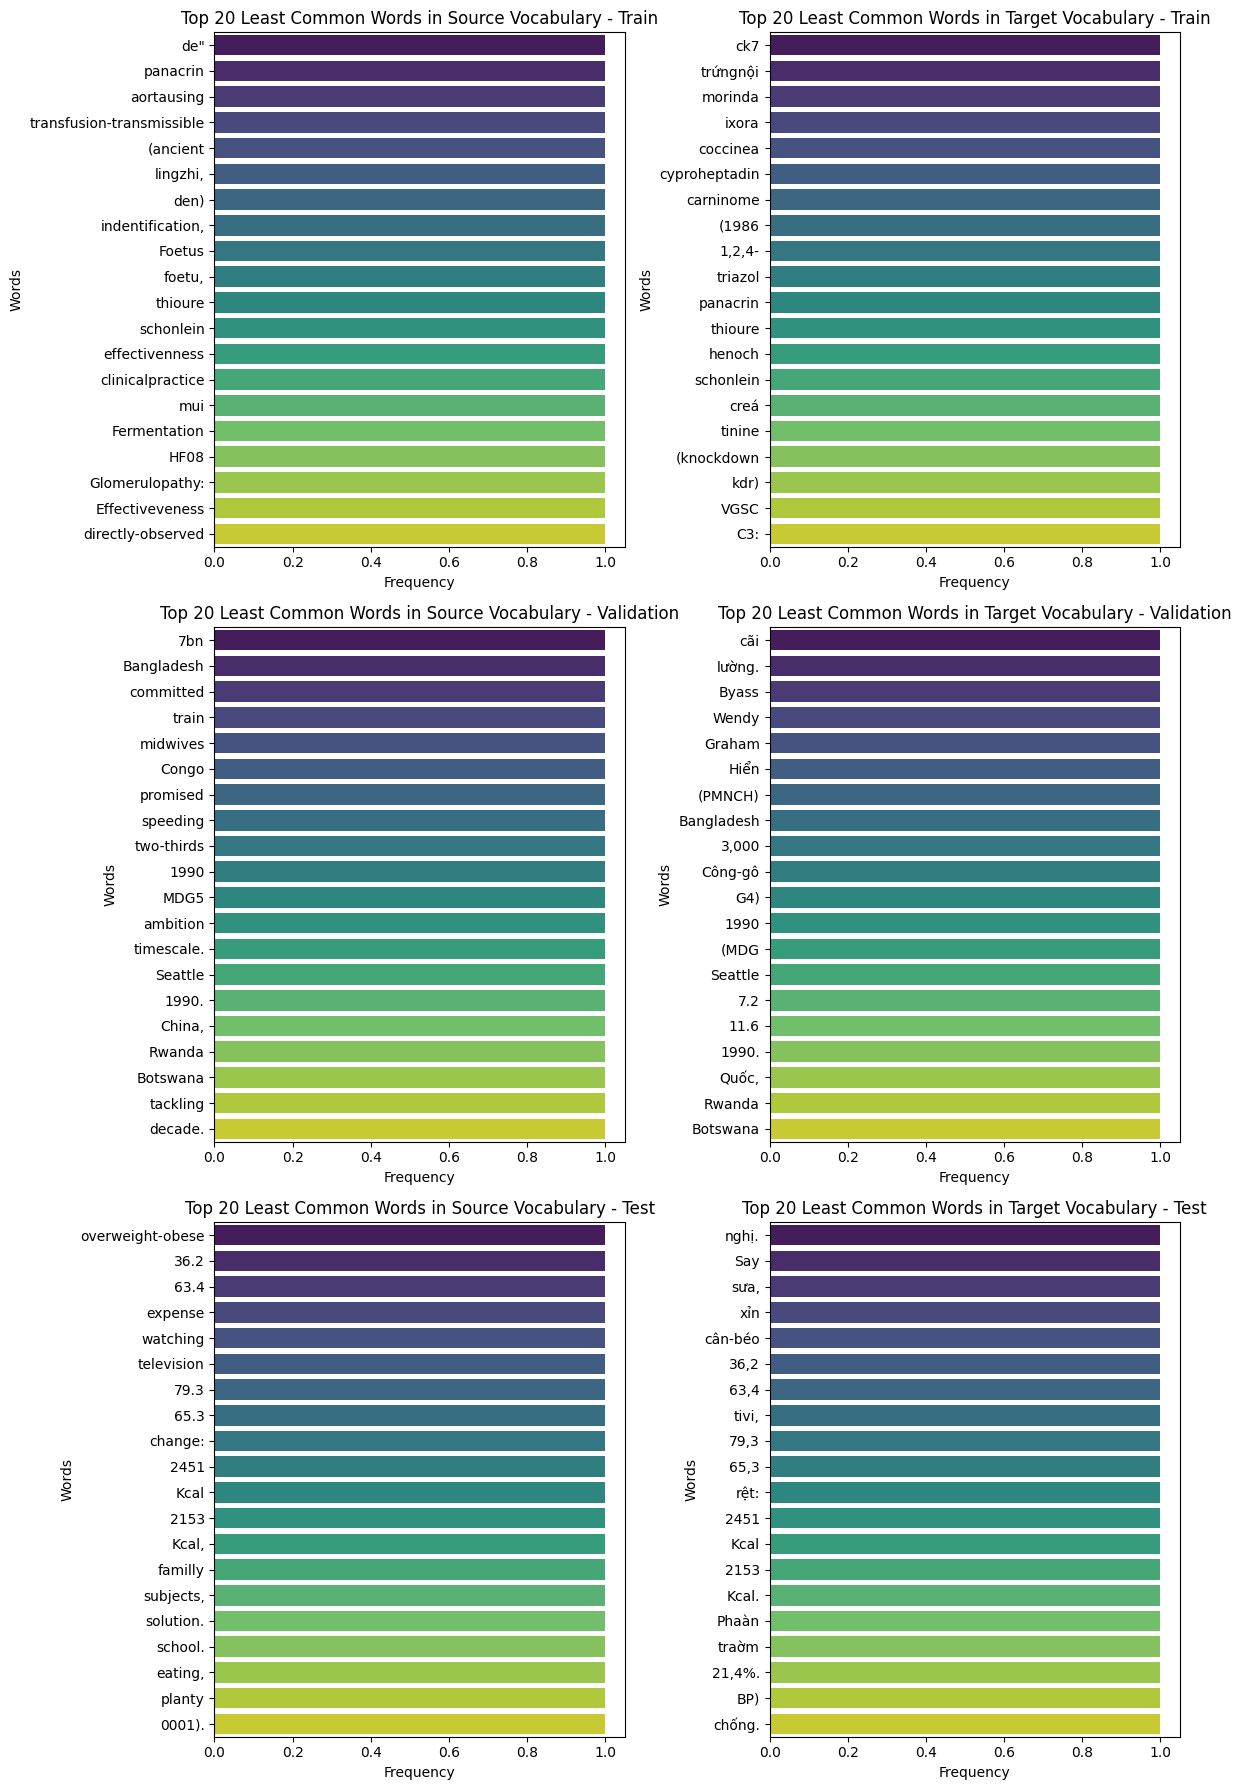

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

# Hàm vẽ histogram cho các tập dữ liệu (Top 20 từ ít phổ biến)
def plot_vocab_histogram(ax, vocab, dataset_name, vocab_type):
    # Lấy 20 từ ít phổ biến nhất
    least_common_words = [word[1] for word in vocab.most_common()[-20:]]  # 20 từ ít phổ biến nhất
    words = [word[0] for word in vocab.most_common()[-20:]]  # Tên các từ ít phổ biến nhất

    # Vẽ biểu đồ histogram
    sns.barplot(x=least_common_words, y=words, palette="viridis", ax=ax)
    ax.set_xlabel('Frequency')
    ax.set_ylabel('Words')
    ax.set_title(f'Top 20 Least Common Words in {vocab_type} Vocabulary - {dataset_name}')

# Tạo figure và axes cho 3 hàng và 2 cột
fig, axes = plt.subplots(3, 2, figsize=(12, 18))

# Vẽ histogram cho mỗi tập dữ liệu
# Tập train
plot_vocab_histogram(axes[0, 0], source_vocab_train, 'Train', 'Source')
plot_vocab_histogram(axes[0, 1], target_vocab_train, 'Train', 'Target')

# Tập validation
plot_vocab_histogram(axes[1, 0], source_vocab_validation, 'Validation', 'Source')
plot_vocab_histogram(axes[1, 1], target_vocab_validation, 'Validation', 'Target')

# Tập test
plot_vocab_histogram(axes[2, 0], source_vocab_test, 'Test', 'Source')
plot_vocab_histogram(axes[2, 1], target_vocab_test, 'Test', 'Target')

# Điều chỉnh khoảng cách giữa các biểu đồ
plt.tight_layout()
plt.show()


#### B. Sau cleaning

<ipython-input-87-fc11caf8ce52>:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=least_common_words, y=words, palette="viridis", ax=ax)
<ipython-input-87-fc11caf8ce52>:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=least_common_words, y=words, palette="viridis", ax=ax)
<ipython-input-87-fc11caf8ce52>:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=least_common_words, y=words, palette="viridis", ax=ax)
<ipython-input-87-fc11caf8ce52>:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed i

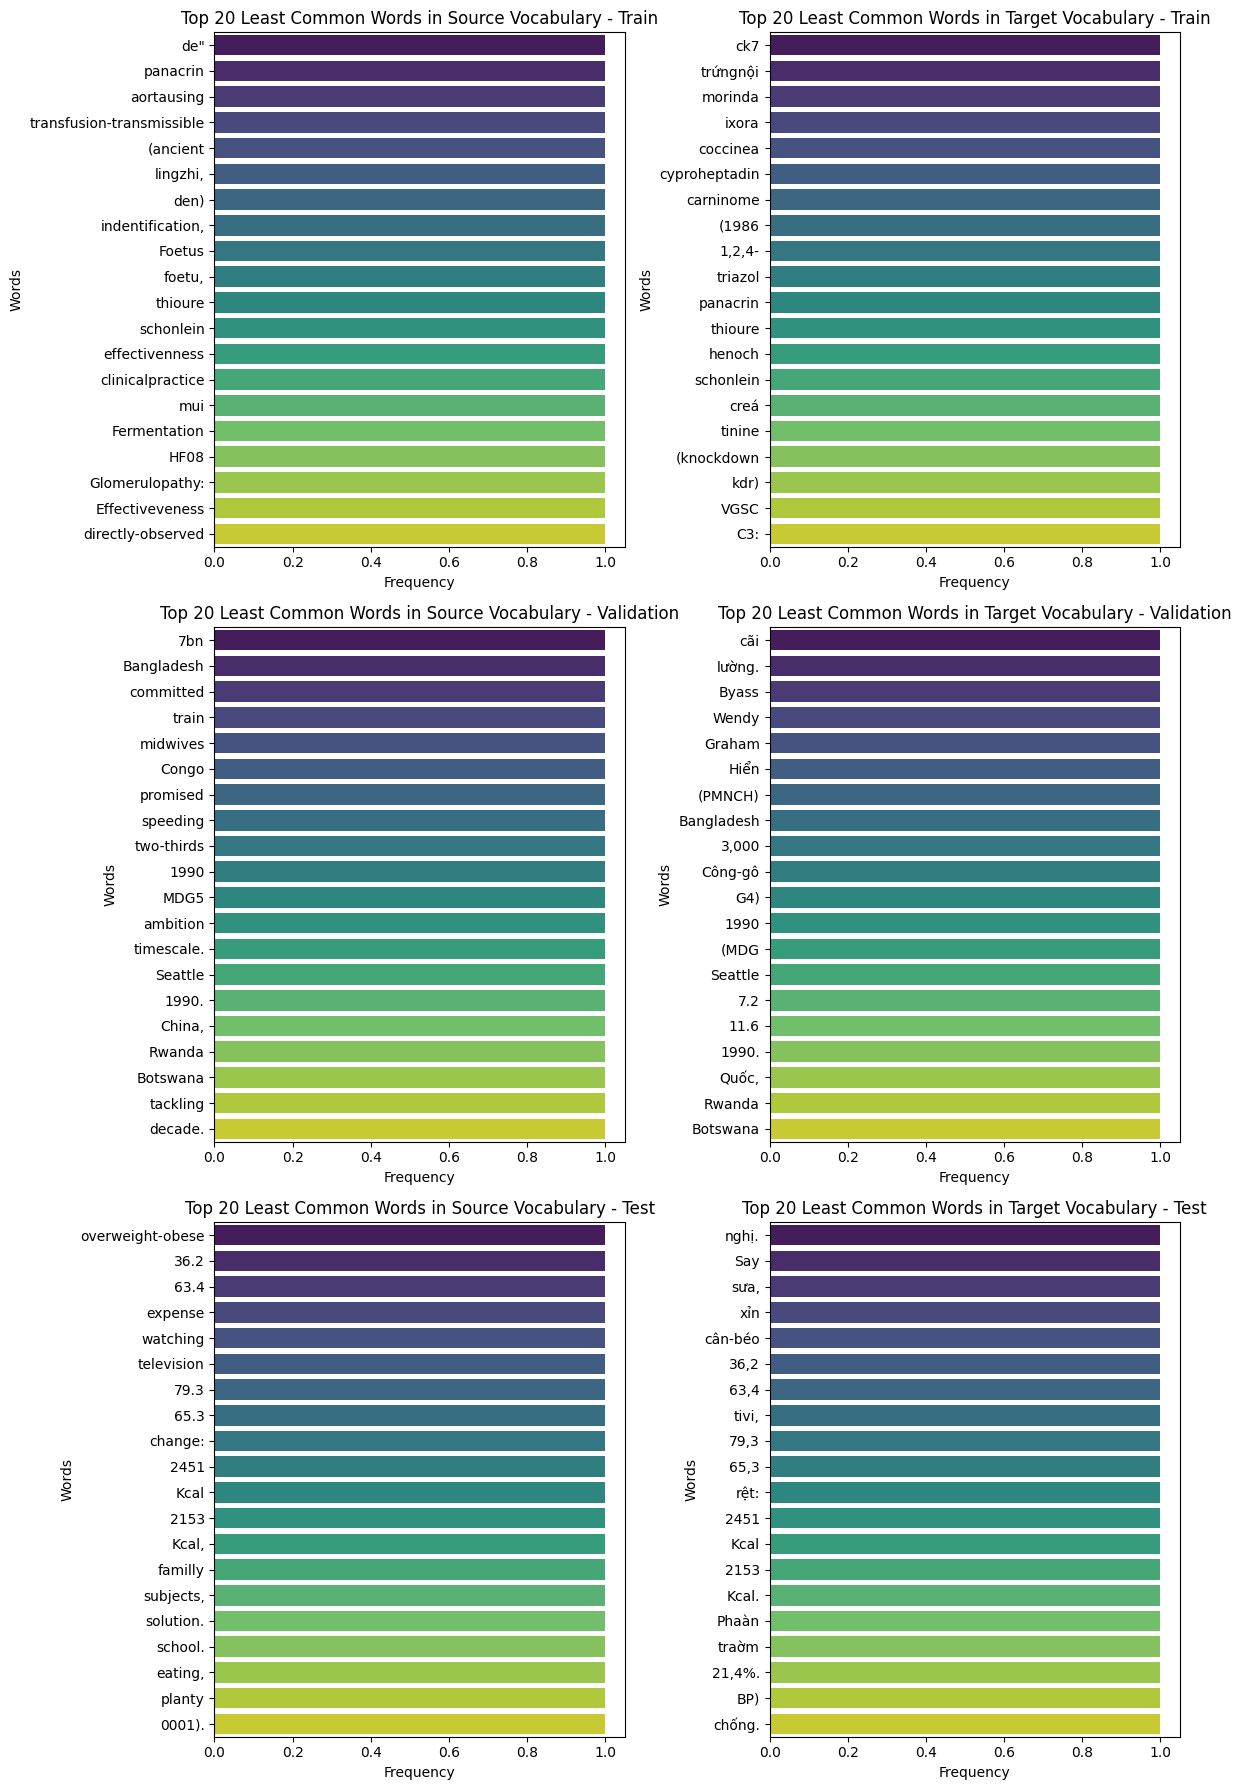

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

# Hàm vẽ histogram cho các tập dữ liệu (Top 20 từ ít phổ biến)
def plot_vocab_histogram(ax, vocab, dataset_name, vocab_type):
    # Lấy 20 từ ít phổ biến nhất
    least_common_words = [word[1] for word in vocab.most_common()[-20:]]  # 20 từ ít phổ biến nhất
    words = [word[0] for word in vocab.most_common()[-20:]]  # Tên các từ ít phổ biến nhất

    # Vẽ biểu đồ histogram
    sns.barplot(x=least_common_words, y=words, palette="viridis", ax=ax)
    ax.set_xlabel('Frequency')
    ax.set_ylabel('Words')
    ax.set_title(f'Top 20 Least Common Words in {vocab_type} Vocabulary - {dataset_name}')

# Tạo figure và axes cho 3 hàng và 2 cột
fig, axes = plt.subplots(3, 2, figsize=(12, 18))

# Vẽ histogram cho mỗi tập dữ liệu
# Tập train
plot_vocab_histogram(axes[0, 0], source_vocab_train, 'Train', 'Source')
plot_vocab_histogram(axes[0, 1], target_vocab_train, 'Train', 'Target')

# Tập validation
plot_vocab_histogram(axes[1, 0], source_vocab_validation, 'Validation', 'Source')
plot_vocab_histogram(axes[1, 1], target_vocab_validation, 'Validation', 'Target')

# Tập test
plot_vocab_histogram(axes[2, 0], source_vocab_test, 'Test', 'Source')
plot_vocab_histogram(axes[2, 1], target_vocab_test, 'Test', 'Target')

# Điều chỉnh khoảng cách giữa các biểu đồ
plt.tight_layout()
plt.show()


## 4.4. Kiểm tra lỗi chính tả và ký tự không hợp lệ

### A. Trước cleaning

In [ ]:
import re
def check_invalid_characters(dataset, column):
    invalid_characters = set()
    for sentence in dataset[column]:
        invalid_characters.update(re.findall(r"[^\w\s.,!?áàảãạăắằẳẵặâấầẩẫậéèẻẽẹêếềểễệíìỉĩịóòỏõọôốồổỗộơớờởỡợúùủũụưứừửữựýỳỷỹỵđ]", sentence))
    return invalid_characters

invalid_source = check_invalid_characters(ds['train'], 'source')
print("Invalid characters in source:", invalid_source)
invalid_target = check_invalid_characters(ds['train'], 'target')
print("Invalid characters in target:", invalid_target)

Invalid characters in source: {'”', '«', '‑', '$', '\uf02d', '✓', '‘', '●', '→', '¬', '‚', '\uf067', '>', '\ufeff', '(', '<', '∗', '×', '≤', '%', "'", '+', '\u200b', '\u200e', '\x02', '⁄', ']', '|', '–', '↑', '}', '^', '~', '™', '{', '\uf0d2', '≥', '»', '#', '↓', '-', '°', '≡', '•', '\uf0a2', '\uf05b', '“', '—', '¥', '\uf026', '‐', '́', '◦', '&', '′', '≈', '\uf06d', '"', '̣', '‟', '®', '\uf0b4', '\uf061', '˂', '§', '―', ';', '\uf020', '\uf0a3', '=', '∆', '˚', '\uf044', '¢', '˃', '*', '†', '‡', '\uf0b3', '⁺', '∛', '\uf0ae', '£', '@', '\uf03c', '\uf0b0', '\\', '\uf76a', '´', ')', '‛', '−', '←', '÷', '‒', '↔', ':', '‰', '\uf062', '\xad', '©', '±', '/', '̀', '’', '[', '`', '\uf05d', '\uf063', '\uf0b1', '̴'}
Invalid characters in target: {'”', '«', '‑', '$', '\uf02d', '✓', '̉', '‘', '℃', '→', '‚', '\uf067', '>', '\ufeff', '(', '<', '×', '≤', '%', "'", '̈', '+', '\u200b', '\u200e', '\u202d', '⁄', ']', '|', '–', '↑', '}', '^', '™', '~', '̃', '{', '\uf0d2', '\uf0b8', '≥', '↓', '#', '-', '°', '

### B. Sau cleaning

In [ ]:
import re
def check_invalid_characters(dataset, column):
    invalid_characters = set()
    for sentence in dataset[column]:
        invalid_characters.update(re.findall(r"[^\w\s.,!?áàảãạăắằẳẵặâấầẩẫậéèẻẽẹêếềểễệíìỉĩịóòỏõọôốồổỗộơớờởỡợúùủũụưứừửữựýỳỷỹỵđ]", sentence))
    return invalid_characters

invalid_source = check_invalid_characters(ds['train'], 'source')
print("Invalid characters in source:", invalid_source)


Invalid characters in source: {'”', '«', '‑', '$', '✓', '‘', '●', '→', '¬', '‚', '>', '(', '<', '∗', '×', '≤', '%', "'", '+', '⁄', ']', '|', '–', '↑', '}', '^', '~', '™', '{', '≥', '»', '#', '↓', '-', '°', '≡', '•', '“', '—', '¥', '‐', '́', '◦', '&', '′', '≈', '"', '̣', '‟', '®', '˂', '§', '―', ';', '=', '∆', '˚', '¢', '˃', '*', '†', '‡', '⁺', '∛', '£', '@', '\\', '´', ')', '‛', '−', '←', '÷', '‒', '↔', ':', '‰', '©', '±', '/', '̀', '’', '[', '`', '̴'}


## 4.5. Bảng mã Unicode (Đọc thêm)

In [ ]:
print(u'\uf02d\uf067\ufeff\uf0ae\uf0b3\uf044\uf0a3\uf020\uf061\uf0b4\uf06d\uf026\uf05b\uf0a2\uf0d2\x02\u200e\u200b\ufeff\uf067\uf02d')

﻿‎​﻿


In [ ]:
print(u'\u0420\u043e\u0441\u0438\u044f')

Росия


In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
!cp "/content/drive/MyDrive/Font Awesome 6 Free-Solid-900.otf" /content

In [ ]:
!pwd

/content


In [ ]:
# Link download
from IPython.core.display import HTML, display

# Chuỗi ký tự PUA
text = "\uf02d\uf067\ufeff\uf0ae\uf0b3\uf044\uf0a3\uf020\uf061\uf0b4\uf06d\uf026\uf05b\uf0a2\uf0d2\x02\u200e\u200b\ufeff\uf067\uf02d"

# HTML để hiển thị text với font hỗ trợ PUA
html_code = f"""
<style>
@font-face {{
    font-family: 'FontAwesome';
    src: url('Font Awesome 6 Free-Solid-900.otf');
}}
div {{
    font-family: 'FontAwesome';
    font-size: 50px;
}}
</style>
<div>
    {text}
</div>
"""
display(HTML(html_code))


# Hiển thị trong Jupyter Notebook
display(HTML(html_code))


In [ ]:
from PIL import Image, ImageDraw, ImageFont

# Chuỗi ký tự PUA
text = "\uf02d\uf067\ufeff\uf0ae\uf0b3\uf044\uf0a3\uf020\uf061\uf0b4\uf06d\uf026\uf05b\uf0a2\uf0d2\x02\u200e\u200b\ufeff\uf067\uf02d"

# Tạo hình ảnh
img = Image.new('RGB', (800, 200), color=(255, 255, 255))
draw = ImageDraw.Draw(img)

# Tải font hỗ trợ PUA (ví dụ: FontAwesome)
font_path = "Font Awesome 6 Free-Solid-900.otf"  # Đường dẫn tới file font
font = ImageFont.truetype(font_path, size=50)
print(font)
# Hiển thị ký tự trên hình ảnh
draw.text((10, 50), text, font=font, fill=(0, 0, 0))

# Hiển thị hình ảnh
img.show()

# Lưu hình ảnh
img.save("output_pua.png")


\## 4.6. Phân tích mức độ song song dữ liệu

### 4.6.1. Tương quan độ dài câu

#### A. Trước Cleaning

In [ ]:
import numpy as np
ratio = [len(target.split()) / len(source.split()) for source, target in zip(ds['train']['source'], ds['train']['target'])]
print("Average length ratio (target/source):", np.mean(ratio))


Average length ratio (target/source): 1.4736899239936043


#### B. Sau Cleaning

In [ ]:
import numpy as np
ratio = [len(target.split()) / len(source.split()) for source, target in zip(ds['train']['source'], ds['train']['target'])]
print("Average length ratio (target/source):", np.mean(ratio))


Average length ratio (target/source): 1.4736747448981922


Kết quả "Average length ratio (target/source): 1.4736747448981922" có thể ảnh hưởng đến quá trình huấn luyện và hiệu suất của mô hình dịch máy (machine translation), đặc biệt là khi sử dụng mô hình Transformer. Dưới đây là những ý nghĩa và tác động của tỷ lệ này đối với mô hình:

1. Chiều dài câu đích (target) dài hơn câu nguồn (source):
Tỷ lệ 1.47 cho thấy rằng, trung bình, câu đích dài hơn khoảng 47% so với câu nguồn. Điều này có thể là kết quả của đặc điểm của ngôn ngữ đích, nơi các câu dịch thường cần nhiều từ hơn để diễn đạt cùng một ý nghĩa (ví dụ, một câu trong tiếng Việt có thể cần nhiều từ hơn để diễn đạt một câu trong tiếng Anh).

Dẫn đến yêu cầu về độ dài đầu ra lớn hơn: Điều này có thể yêu cầu mô hình học được cách tạo ra câu đích dài hơn câu nguồn và xử lý các trường hợp cần thêm từ, các yếu tố ngữ pháp, hoặc các từ ngữ bổ sung trong ngữ cảnh dịch thuật.

2. Tác động đến kích thước đầu ra và bộ đệm của mô hình Transformer:
Transformer sử dụng cơ chế self-attention để xử lý toàn bộ câu cùng một lúc. Khi câu đích dài hơn câu nguồn, mô hình cần bộ nhớ và tính toán lớn hơn để xử lý các câu dài hơn.

Độ dài đầu vào và đầu ra thay đổi: Các câu dịch dài hơn có thể làm tăng số lượng từ trong chuỗi đầu ra, ảnh hưởng đến độ dài của các bước trong quá trình huấn luyện và số lượng token mà mô hình phải xử lý.

Truyền thông tin từ nguồn đến đích: Với các câu đích dài hơn, mô hình cần đảm bảo rằng thông tin từ câu nguồn được dịch đúng cách và không bị mất trong quá trình dịch. Điều này có thể đòi hỏi mô hình học các mối quan hệ và cấu trúc ngữ pháp phức tạp hơn giữa các câu nguồn và đích.

3. Vấn đề về padding và truncation:
Khi xử lý các câu có độ dài khác nhau, bạn có thể phải sử dụng padding (thêm token để câu đạt chiều dài cố định) hoặc truncation (cắt bớt các câu quá dài). Nếu tỷ lệ độ dài này lớn, câu đích có thể cần padding nhiều hơn câu nguồn, ảnh hưởng đến hiệu suất huấn luyện.
Mô hình có thể gặp vấn đề khi padding quá nhiều, làm giảm khả năng học của mô hình. Ngược lại, nếu câu đích bị cắt bớt quá nhiều, mô hình có thể không học được đầy đủ thông tin.
4. Chiến lược tối ưu hóa:
Việc câu đích dài hơn câu nguồn có thể giúp mô hình Transformer hiểu rằng tính đa dạng của các câu đích có thể bao gồm cả việc thêm từ ngữ mới hoặc các yếu tố ngữ pháp bổ sung.
Bạn có thể điều chỉnh các tham số của mô hình, chẳng hạn như max sequence length (chiều dài chuỗi tối đa) và learning rate để giúp mô hình thích nghi với độ dài của đầu vào và đầu ra.
5. Khả năng dịch các câu dài hơn:
Một tỷ lệ dài hơn như vậy có thể là dấu hiệu cho thấy mô hình có thể gặp khó khăn khi dịch các câu có độ dài chênh lệch lớn giữa nguồn và đích.
Mô hình cần học cách giữ lại cấu trúc của câu nguồn khi dịch sang một ngôn ngữ đích có cấu trúc khác (ví dụ, một số ngôn ngữ có cách dùng từ dài hơn hoặc phức tạp hơn).
6. Hiệu quả của Beam Search trong dịch:
Beam Search là một kỹ thuật được sử dụng trong Transformer để tìm kiếm các câu dịch tối ưu. Với tỷ lệ độ dài này, bạn có thể cần điều chỉnh beam size để mô hình có thể tìm ra các giải pháp dịch tốt hơn cho các câu dài hơn.
7. Khả năng tạo ra câu hoàn chỉnh hơn:
Với tỷ lệ dài như vậy, mô hình có thể học được cách xây dựng câu đích không chỉ phù hợp với câu nguồn về ngữ nghĩa mà còn đáp ứng được độ dài và các yếu tố ngữ pháp yêu cầu, chẳng hạn như chia động từ, thêm chủ ngữ hoặc từ nối.
Tóm lại:
Kết quả tỷ lệ 1.47 có thể cung cấp thông tin quan trọng về sự chênh lệch độ dài giữa câu nguồn và câu đích. Điều này giúp bạn hiểu rằng mô hình sẽ cần điều chỉnh để xử lý các câu đích dài hơn, đảm bảo tính chính xác và mượt mà trong việc dịch thuật. Hệ thống có thể yêu cầu thêm tài nguyên tính toán hoặc các chiến lược tối ưu hóa khi dịch các câu dài hơn, đồng thời xử lý tốt hơn các vấn đề liên quan đến padding và truncation.

### 4.6.2. Tương quan về mặc ngữ nghĩa

#### 4.6.2.1. Test thử với 1 câu

##### A. Anh-Anh

In [ ]:
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity

# Tải model Sentence-BERT
tokenizer = XLMRobertaTokenizer.from_pretrained('xlm-roberta-base')
model = XLMRobertaModel.from_pretrained('xlm-roberta-base')


# Các câu cần đo độ tương đồng
sentence1 = "I am learning machine translation."
sentence2 = "I study how to translate between languages using machines."

# Lấy embedding của các câu
embedding1 = model.encode([sentence1])
embedding2 = model.encode([sentence2])

# Tính toán độ tương đồng cosine
similarity = cosine_similarity(embedding1, embedding2)

print(f"Cosine similarity between the sentences: {similarity[0][0]:.4f}")


modules.json:   0%|          | 0.00/229 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/122 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/3.73k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/629 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/314 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Cosine similarity between the sentences: 0.6657


##### B. Anh-Viet

In [ ]:
from transformers import XLMRobertaTokenizer, XLMRobertaModel
import torch
from sklearn.metrics.pairwise import cosine_similarity

# Tải model và tokenizer XLM-R
tokenizer = XLMRobertaTokenizer.from_pretrained('xlm-roberta-base')
model = XLMRobertaModel.from_pretrained('xlm-roberta-base')

# Câu tiếng Anh và câu tiếng Việt
source_text = "How are you?"
target_text = "Bạn khỏe không?"

# Hàm tính cosine similarity cho mỗi cặp câu
def calculate_similarity(source, target):
    # Tokenize source và target
    source_enc = tokenizer(source, return_tensors='pt', padding=True, truncation=True, max_length=128)
    target_enc = tokenizer(target, return_tensors='pt', padding=True, truncation=True, max_length=128)

    # Lấy embedding cho source và target
    source_embedding = model(**source_enc).last_hidden_state.mean(dim=1)
    target_embedding = model(**target_enc).last_hidden_state.mean(dim=1)

    # Tính cosine similarity
    similarity = cosine_similarity(source_embedding.detach().numpy(), target_embedding.detach().numpy())[0][0]
    return similarity

# Tính độ tương đồng ngữ nghĩa giữa câu tiếng Anh và tiếng Việt
similarity = calculate_similarity(source_text, target_text)

# In kết quả
print(f"Semantic Similarity between the English and Vietnamese sentence: {similarity:.4f}")


Semantic Similarity between the English and Vietnamese sentence: 0.9938


#### 4.6.2.2. Áp dụng lên dataset

##### A. Trước cleaning

In [ ]:
from transformers import XLMRobertaTokenizer, XLMRobertaModel
import torch
from sklearn.metrics.pairwise import cosine_similarity

# Tải model và tokenizer XLM-R
tokenizer = XLMRobertaTokenizer.from_pretrained('xlm-roberta-base')
model = XLMRobertaModel.from_pretrained('xlm-roberta-base')

# Hàm tính cosine similarity cho mỗi cặp câu (source, target)
def calculate_similarity(dataset):
    similarities = []
    for source, target in zip(dataset['source'], dataset['target']):
        # Lấy embedding cho source và target
        source_enc = tokenizer(source, return_tensors='pt', padding=True, truncation=True, max_length=128)
        target_enc = tokenizer(target, return_tensors='pt', padding=True, truncation=True, max_length=128)

        source_embedding = model(**source_enc).last_hidden_state.mean(dim=1)
        target_embedding = model(**target_enc).last_hidden_state.mean(dim=1)

        # Tính cosine similarity
        similarity = cosine_similarity(source_embedding.detach().numpy(), target_embedding.detach().numpy())[0][0]
        similarities.append(similarity)

    return similarities

# Tính độ tương đồng ngữ nghĩa cho từng tập dữ liệu (train, validation, test)
# train_similarities = calculate_similarity(ds['train'])
# validation_similarities = calculate_similarity(ds['validation'])
# test_similarities = calculate_similarity(ds['test'])
# Lấy mẫu ngẫu nhiên từ dataset
sample_train = {'source': ds['train']['source'][:1000], 'target': ds['train']['target'][:1000]}
sample_validation = {'source': ds['validation']['source'][:1000], 'target': ds['validation']['target'][:1000]}
sample_test = {'source': ds['test']['source'][:1000], 'target': ds['test']['target'][:1000]}

# Áp dụng trên tập mẫu
train_similarities = calculate_similarity(sample_train)
validation_similarities = calculate_similarity(sample_validation)
test_similarities = calculate_similarity(sample_test)

# Tính toán giá trị trung bình của cosine similarity
avg_train_similarity = np.mean(train_similarities)
avg_validation_similarity = np.mean(validation_similarities)
avg_test_similarity = np.mean(test_similarities)

# In kết quả
print(f"Average Semantic Similarity (Train): {avg_train_similarity:.4f}")
print(f"Average Semantic Similarity (Validation): {avg_validation_similarity:.4f}")
print(f"Average Semantic Similarity (Test): {avg_test_similarity:.4f}")


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.10M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/615 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.12G [00:00<?, ?B/s]

NameError: name 'np' is not defined

##### B. Sau cleaning

In [ ]:
from transformers import XLMRobertaTokenizer, XLMRobertaModel
import torch
from sklearn.metrics.pairwise import cosine_similarity

# Tải model và tokenizer XLM-R
tokenizer = XLMRobertaTokenizer.from_pretrained('xlm-roberta-base')
model = XLMRobertaModel.from_pretrained('xlm-roberta-base')

# Hàm tính cosine similarity cho mỗi cặp câu (source, target)
def calculate_similarity(dataset):
    similarities = []
    for source, target in zip(dataset['source'], dataset['target']):
        # Lấy embedding cho source và target
        source_enc = tokenizer(source, return_tensors='pt', padding=True, truncation=True, max_length=128)
        target_enc = tokenizer(target, return_tensors='pt', padding=True, truncation=True, max_length=128)

        source_embedding = model(**source_enc).last_hidden_state.mean(dim=1)
        target_embedding = model(**target_enc).last_hidden_state.mean(dim=1)

        # Tính cosine similarity
        similarity = cosine_similarity(source_embedding.detach().numpy(), target_embedding.detach().numpy())[0][0]
        similarities.append(similarity)

    return similarities

# Tính độ tương đồng ngữ nghĩa cho từng tập dữ liệu (train, validation, test)
# train_similarities = calculate_similarity(ds['train'])
# validation_similarities = calculate_similarity(ds['validation'])
# test_similarities = calculate_similarity(ds['test'])
# Lấy mẫu ngẫu nhiên từ dataset
sample_train = {'source': ds['train']['source'][:1000], 'target': ds['train']['target'][:1000]}
sample_validation = {'source': ds['validation']['source'][:1000], 'target': ds['validation']['target'][:1000]}
sample_test = {'source': ds['test']['source'][:1000], 'target': ds['test']['target'][:1000]}

# Áp dụng trên tập mẫu
train_similarities = calculate_similarity(sample_train)
validation_similarities = calculate_similarity(sample_validation)
test_similarities = calculate_similarity(sample_test)

# Tính toán giá trị trung bình của cosine similarity
avg_train_similarity = np.mean(train_similarities)
avg_validation_similarity = np.mean(validation_similarities)
avg_test_similarity = np.mean(test_similarities)

# In kết quả
print(f"Average Semantic Similarity (Train): {avg_train_similarity:.4f}")
print(f"Average Semantic Similarity (Validation): {avg_validation_similarity:.4f}")
print(f"Average Semantic Similarity (Test): {avg_test_similarity:.4f}")


Average Semantic Similarity (Train): 0.9973
Average Semantic Similarity (Validation): 0.9973
Average Semantic Similarity (Test): 0.9973


## 4.7. Phân tích thuật ngữ chuyên ngành (Domain-Specific Terms)

### A. Trước Cleaning

In [ ]:
medical_terms = ['otitis', 'media', 'effusion', 'V.a', 'department']
for term in medical_terms:
    print(f"Occurrences of '{term}' in source:", sum(term in sentence for sentence in ds['train']['source']))


Occurrences of 'otitis' in source: 303
Occurrences of 'media' in source: 5164
Occurrences of 'effusion' in source: 802
Occurrences of 'V.a' in source: 1
Occurrences of 'department' in source: 2241


### B. Sau Cleaning

In [ ]:
medical_terms = ['otitis', 'media', 'effusion', 'V.a', 'department']
for term in medical_terms:
    print(f"Occurrences of '{term}' in source:", sum(term in sentence for sentence in ds['train']['source']))


Occurrences of 'otitis' in source: 303
Occurrences of 'media' in source: 5164
Occurrences of 'effusion' in source: 802
Occurrences of 'V.a' in source: 1
Occurrences of 'department' in source: 2241


## 4.8. Phân tích chất lượng dữ liệu dịch (Quality Assessment)

### A. Trước Cleaning

In [ ]:
for source, target in zip(ds['train']['source'], ds['train']['target']):
    if len(source) < 10 or len(target) < 10:
        print("Potential issue:", source, "->", target)


Potential issue: Methods. -> Đối tượng-Phương pháp nghiên cứu.
Potential issue: Method. -> Đối tượng - Phương pháp nghiên cứu.
Potential issue: 35.4%. -> 35,4%.
Potential issue: 2, 15%. -> 2,15%.
Potential issue: Result. -> Khung lý thuyết được xây dựng dựa trên học thuyết Meleis, đánh giá các khái niệm cá nhân, xã hội và cộng đồng tác động lên chuyển đổi vai trò của sinh viên điều dưỡng trong bối cảnh COVID-19, từ đó phát hiện các khái niệm mới.
Potential issue: was of 3, 8%. -> 3,8%.
Potential issue: Method. -> Phương pháp nghiên cứu.
Potential issue: by DMSO. -> bằng DMSO được tiến hành.
Potential issue: Methods. -> Đối tượng – phương pháp nghiên cứu.
Potential issue: Flu -> Bệnh cúm
Potential issue: Results. -> Kết luận.
Potential issue: (P<0.05). -> (P < 0,05).
Potential issue: (5.79%). -> (5,79%).
Potential issue: Methods. -> Đối tượng - phương pháp nghiên cứu.
Potential issue: Pomegranate -> Cây Lựu
Potential issue: nana. -> nana.
Potential issue: Aloe vera -> Cây Lô hội
Potenti

### B. Sau Cleaning

In [ ]:
for source, target in zip(ds['train']['source'], ds['train']['target']):
    if len(source) < 10 or len(target) < 10:
        print("Potential issue:", source, "->", target)


Potential issue: Methods. -> Đối tượng-Phương pháp nghiên cứu.
Potential issue: Method. -> Đối tượng - Phương pháp nghiên cứu.
Potential issue: 35.4%. -> 35,4%.
Potential issue: 2, 15%. -> 2,15%.
Potential issue: Result. -> Khung lý thuyết được xây dựng dựa trên học thuyết Meleis, đánh giá các khái niệm cá nhân, xã hội và cộng đồng tác động lên chuyển đổi vai trò của sinh viên điều dưỡng trong bối cảnh COVID-19, từ đó phát hiện các khái niệm mới.
Potential issue: was of 3, 8%. -> 3,8%.
Potential issue: Method. -> Phương pháp nghiên cứu.
Potential issue: by DMSO. -> bằng DMSO được tiến hành.
Potential issue: Methods. -> Đối tượng – phương pháp nghiên cứu.
Potential issue: Flu -> Bệnh cúm
Potential issue: Results. -> Kết luận.
Potential issue: (P<0.05). -> (P < 0,05).
Potential issue: (5.79%). -> (5,79%).
Potential issue: Methods. -> Đối tượng - phương pháp nghiên cứu.
Potential issue: Pomegranate -> Cây Lựu
Potential issue: nana. -> nana.
Potential issue: Aloe vera -> Cây Lô hội
Potenti

Mục đích của đoạn code:
Phát hiện vấn đề tiềm ẩn: Đoạn code giúp phát hiện những câu có độ dài quá ngắn, có thể gây ra các vấn đề khi huấn luyện mô hình dịch máy, vì những câu quá ngắn có thể không chứa đủ ngữ nghĩa hoặc thông tin cho mô hình học.
Phân tích dữ liệu: Việc in ra các cặp câu nguồn và câu đích này sẽ giúp người dùng phát hiện được các vấn đề dữ liệu cần được xử lý, như là loại bỏ các câu quá ngắn hoặc thực hiện các biện pháp xử lý dữ liệu khác (chẳng hạn như thêm dữ liệu vào hoặc thay thế bằng câu mẫu).
Ví dụ:
Giả sử có các cặp câu sau:

source = "Hi", target = "Xin chào"
source = "Good morning", target = "Chào buổi sáng"
Với đoạn mã trên:

Cặp câu đầu tiên sẽ bị in ra vì câu nguồn có độ dài là 2 ký tự (ít hơn 10 ký tự).
Cặp câu thứ hai sẽ không bị in ra vì cả hai câu đều có độ dài lớn hơn 10 ký tự.
Tóm lại:
Đoạn mã này giúp bạn kiểm tra và phát hiện các câu nguồn hoặc câu đích có độ dài quá ngắn trong tập huấn luyện, từ đó có thể xử lý chúng nếu cần thiết.

## 4.9. So sánh dữ liệu của tập validation/test

### A. Trước Cleaning

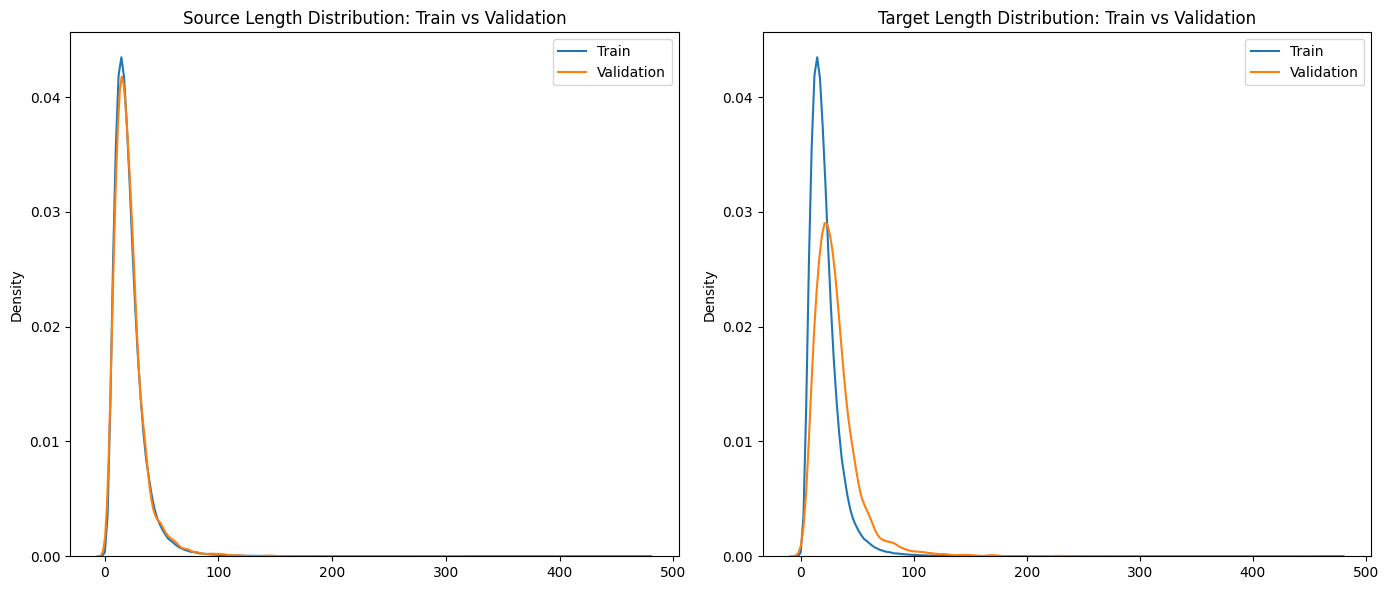

In [ ]:
def compare_distributions(train_lengths, valid_lengths, ax, title="Distribution Comparison"):
    import seaborn as sns
    import matplotlib.pyplot as plt  # Đảm bảo rằng bạn đã import matplotlib.pyplot

    sns.kdeplot(train_lengths, label='Train', ax=ax)
    sns.kdeplot(valid_lengths, label='Validation', ax=ax)

    ax.legend()
    ax.set_title(title)  # Thêm tiêu đề cho đồ thị

# Tạo một đồ thị với 1 hàng 2 cột
fig, axes = plt.subplots(1, 2, figsize=(14, 6))  # 1 hàng, 2 cột

# So sánh độ dài của câu trong dữ liệu huấn luyện và dữ liệu kiểm tra (source)
compare_distributions(source_lengths, get_length_distribution(ds['validation'], 'source'),
                      axes[0], title="Source Length Distribution: Train vs Validation")

# So sánh độ dài của câu trong dữ liệu huấn luyện và dữ liệu kiểm tra (target)
compare_distributions(source_lengths, get_length_distribution(ds['validation'], 'target'),
                      axes[1], title="Target Length Distribution: Train vs Validation")

plt.tight_layout()  # Đảm bảo các đồ thị không bị chồng lấp
plt.show()


### B. Sau Cleaning

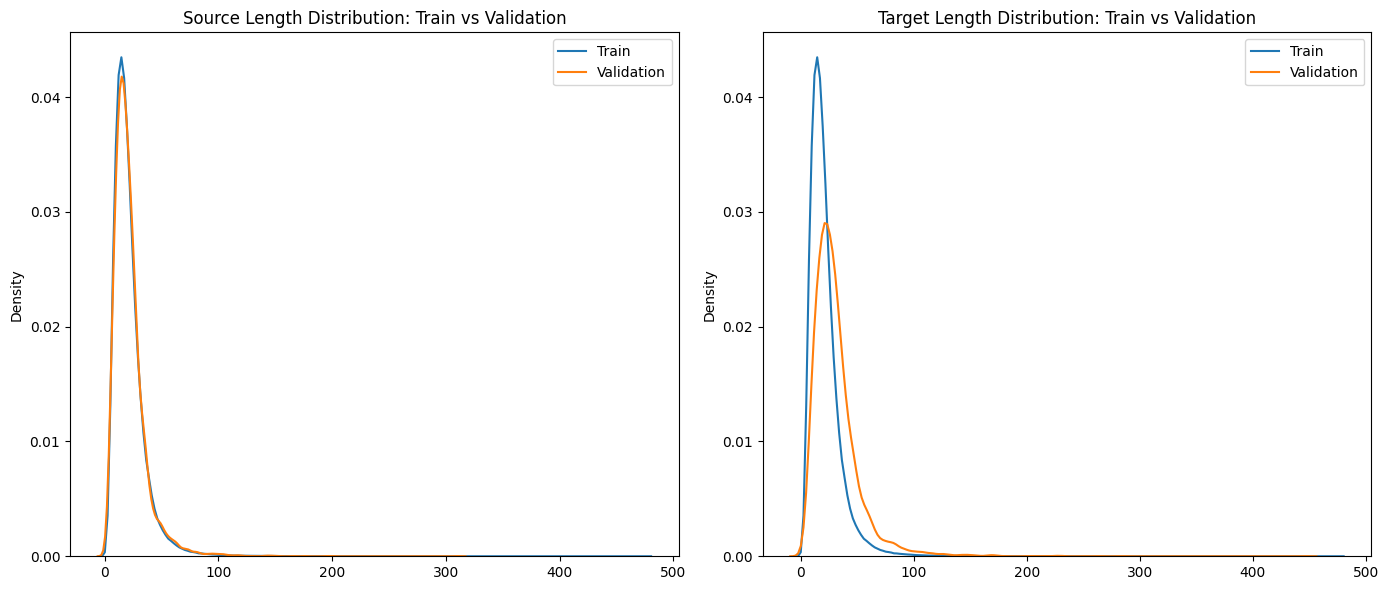

In [ ]:
def compare_distributions(train_lengths, valid_lengths, ax, title="Distribution Comparison"):
    import seaborn as sns
    import matplotlib.pyplot as plt  # Đảm bảo rằng bạn đã import matplotlib.pyplot

    sns.kdeplot(train_lengths, label='Train', ax=ax)
    sns.kdeplot(valid_lengths, label='Validation', ax=ax)

    ax.legend()
    ax.set_title(title)  # Thêm tiêu đề cho đồ thị

# Tạo một đồ thị với 1 hàng 2 cột
fig, axes = plt.subplots(1, 2, figsize=(14, 6))  # 1 hàng, 2 cột

# So sánh độ dài của câu trong dữ liệu huấn luyện và dữ liệu kiểm tra (source)
compare_distributions(source_lengths, get_length_distribution(ds['validation'], 'source'),
                      axes[0], title="Source Length Distribution: Train vs Validation")

# So sánh độ dài của câu trong dữ liệu huấn luyện và dữ liệu kiểm tra (target)
compare_distributions(source_lengths, get_length_distribution(ds['validation'], 'target'),
                      axes[1], title="Target Length Distribution: Train vs Validation")

plt.tight_layout()  # Đảm bảo các đồ thị không bị chồng lấp
plt.show()


Chức năng của đoạn mã:
Mục đích của đoạn mã là so sánh phân phối độ dài câu của dữ liệu huấn luyện và dữ liệu kiểm tra bằng cách vẽ đồ thị phân phối mật độ kernel (KDE plot) của các độ dài câu. Khi bạn sử dụng hàm compare_distributions, nó sẽ vẽ hai đồ thị KDE, một cho tập huấn luyện và một cho tập kiểm tra, giúp bạn dễ dàng nhận biết sự khác biệt về phân phối độ dài giữa hai tập dữ liệu này.

Ví dụ về kết quả:
KDE Plot của train_lengths và valid_lengths: Nếu hai phân phối này có hình dạng tương tự, điều đó có thể cho thấy rằng dữ liệu huấn luyện và kiểm tra có độ dài câu khá tương đồng. Nếu có sự chênh lệch rõ rệt, có thể dữ liệu kiểm tra có câu dài hơn hoặc ngắn hơn so với dữ liệu huấn luyện, điều này có thể yêu cầu điều chỉnh trong quá trình huấn luyện mô hình.
Tóm tắt:
Đoạn mã này giúp bạn trực quan hóa sự khác biệt hoặc sự tương đồng trong phân phối độ dài câu giữa dữ liệu huấn luyện và dữ liệu kiểm tra, từ đó hỗ trợ việc điều chỉnh hoặc đánh giá dữ liệu khi xây dựng mô hình machine translation.

## 4.10. Kết luận:

Sau khi phân tích dữ liệu, ta dùng hàm cleaning để loại bỏ các kí tự Unicode
không cần thiết đưa vào trainning cũng như không có ý nghĩa về mặc ngữ nghĩa

# 5. Thống kê dữ liệu sau khi qua PP Tokenizer

## 5.1. Phương pháp tokenizer dùng "google-bert/bert-base-multilingual-cased"

In [ ]:
from transformers import BertTokenizer
from datasets import DatasetDict  # Để phù hợp với cấu trúc dataset của bạn
from transformers import AutoTokenizer, AutoModelForMaskedLM

# Tải tokenizer (ví dụ: mBART hoặc T5)
tokenizer = AutoTokenizer.from_pretrained("google-bert/bert-base-multilingual-cased")


# Tokenize function để áp dụng lên toàn bộ dataset
def tokenize_function(examples):
    # Tokenize cả source và target
    source_encodings = tokenizer(
        examples['source'],
        add_special_tokens=True,  # Thêm các token [CLS] và [SEP]
        truncation=True,          # Cắt ngắn nếu quá dài
        padding="max_length",     # Padding đến độ dài tối đa
        max_length=128,           # Giới hạn độ dài (tùy chọn)
        return_tensors="pt"       # Trả về tensors PyTorch
    )

    target_encodings = tokenizer(
        examples['target'],
        add_special_tokens=True,
        truncation=True,
        padding="max_length",
        max_length=128,
        return_tensors="pt"
    )

    return {
        "input_ids_source": source_encodings['input_ids'][0].tolist(),
        "tokens_source": tokenizer.convert_ids_to_tokens(source_encodings['input_ids'][0]),
        "input_ids_target": target_encodings['input_ids'][0].tolist(),
        "tokens_target": tokenizer.convert_ids_to_tokens(target_encodings['input_ids'][0])
    }

# Tokenize toàn bộ dataset
tokenized_datasets = ds.map(tokenize_function, batched=False)

# Xem mẫu đầu tiên trong tập train sau khi tokenize
print("Tokenized dataset example:", tokenized_datasets['train'][0])


tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/625 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/996k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.96M [00:00<?, ?B/s]

Map:   0%|          | 0/340897 [00:00<?, ? examples/s]

Map:   0%|          | 0/8939 [00:00<?, ? examples/s]

Map:   0%|          | 0/8960 [00:00<?, ? examples/s]

Tokenized dataset example: {'source': 'To evaluate clinical, subclinical symptoms of patients with otitis media with effusion and V.a at otorhinolaryngology department – Thai Nguyen national hospital', 'target': 'Nghiên cứu đặc điểm lâm sàng, cận lâm sàng bệnh nhân viêm tai ứ dịch trên viêm V.A tại Khoa Tai mũi họng - Bệnh viện Trung ương Thái Nguyên', 'input_ids_source': [101, 11469, 103730, 107114, 10112, 43463, 117, 13987, 86257, 17616, 62319, 10108, 25965, 10169, 60818, 36967, 12518, 10169, 56331, 55729, 11046, 10111, 159, 119, 169, 10160, 60818, 10667, 107485, 10774, 13379, 31002, 37652, 21079, 100, 26207, 91961, 11844, 18141, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'tokens_source': ['[CLS]', 'To', 'eva', '##luat', '##e', 'clinical', ',', 'sub', '##clin',

In [ ]:
print("Tokenized dataset example:", tokenized_datasets['train'][0])

Tokenized dataset example: {'source': 'To evaluate clinical, subclinical symptoms of patients with otitis media with effusion and V.a at otorhinolaryngology department – Thai Nguyen national hospital', 'target': 'Nghiên cứu đặc điểm lâm sàng, cận lâm sàng bệnh nhân viêm tai ứ dịch trên viêm V.A tại Khoa Tai mũi họng - Bệnh viện Trung ương Thái Nguyên', 'input_ids_source': [101, 11469, 103730, 107114, 10112, 43463, 117, 13987, 86257, 17616, 62319, 10108, 25965, 10169, 60818, 36967, 12518, 10169, 56331, 55729, 11046, 10111, 159, 119, 169, 10160, 60818, 10667, 107485, 10774, 13379, 31002, 37652, 21079, 100, 26207, 91961, 11844, 18141, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'tokens_source': ['[CLS]', 'To', 'eva', '##luat', '##e', 'clinical', ',', 'sub', '##clin',

## 5.2 Xem cấu trúc của dataset sau khi thực hiện tokenizer

In [ ]:
print(tokenized_datasets)

DatasetDict({
    train: Dataset({
        features: ['source', 'target', 'input_ids_source', 'tokens_source', 'input_ids_target', 'tokens_target'],
        num_rows: 340897
    })
    validation: Dataset({
        features: ['source', 'target', 'input_ids_source', 'tokens_source', 'input_ids_target', 'tokens_target'],
        num_rows: 8939
    })
    test: Dataset({
        features: ['source', 'target', 'input_ids_source', 'tokens_source', 'input_ids_target', 'tokens_target'],
        num_rows: 8960
    })
})


## 5.3. Thống kê lại phân phối số lượng subword của Vocabulary

<ipython-input-110-17dd8c0c80eb>:42: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=counts, y=words, palette="viridis")


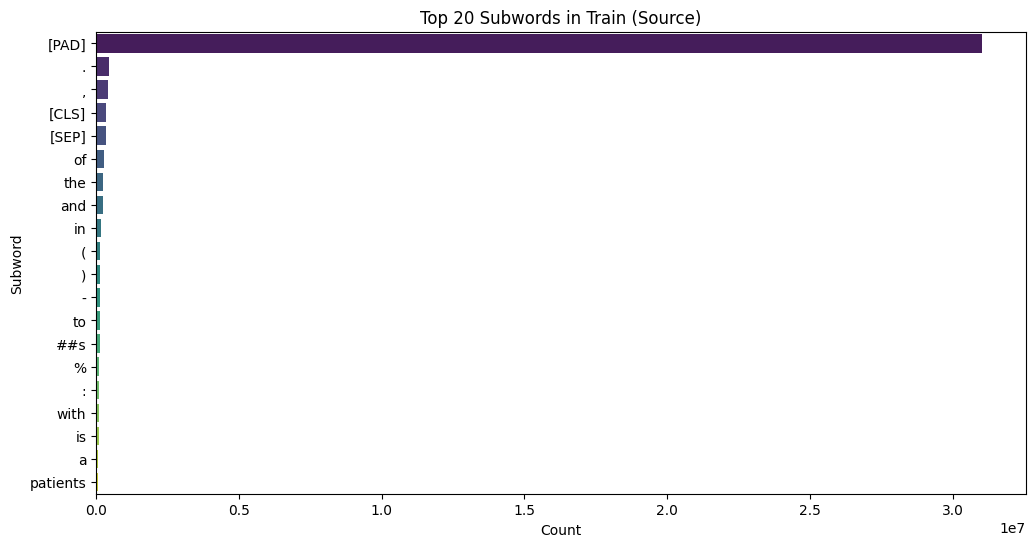

<ipython-input-110-17dd8c0c80eb>:42: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=counts, y=words, palette="viridis")


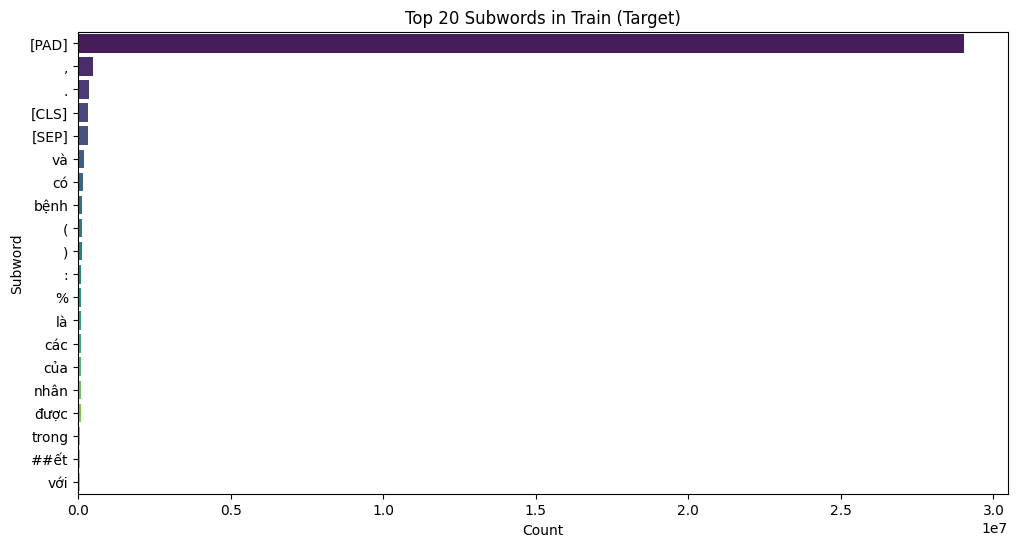

<ipython-input-110-17dd8c0c80eb>:42: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=counts, y=words, palette="viridis")


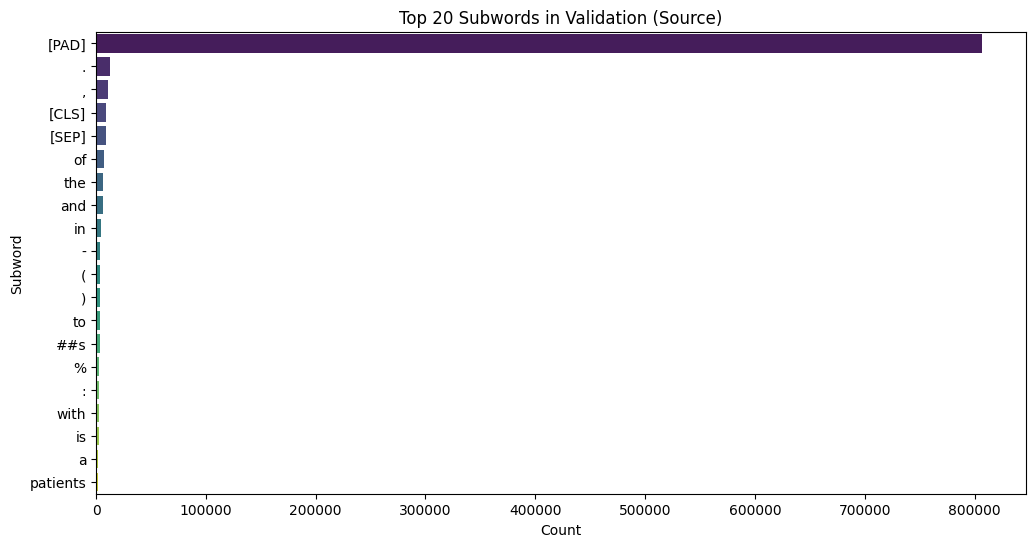

<ipython-input-110-17dd8c0c80eb>:42: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=counts, y=words, palette="viridis")


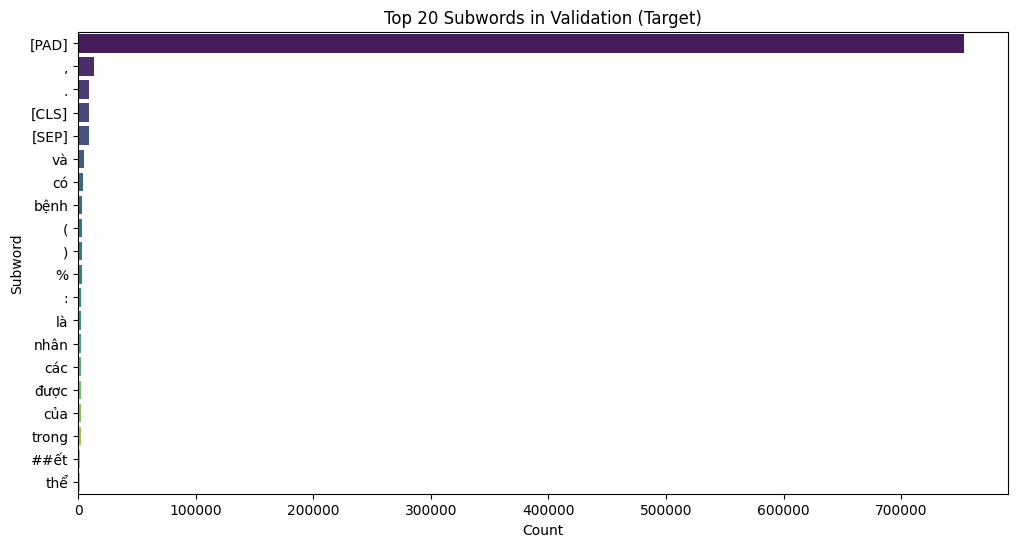

<ipython-input-110-17dd8c0c80eb>:42: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=counts, y=words, palette="viridis")


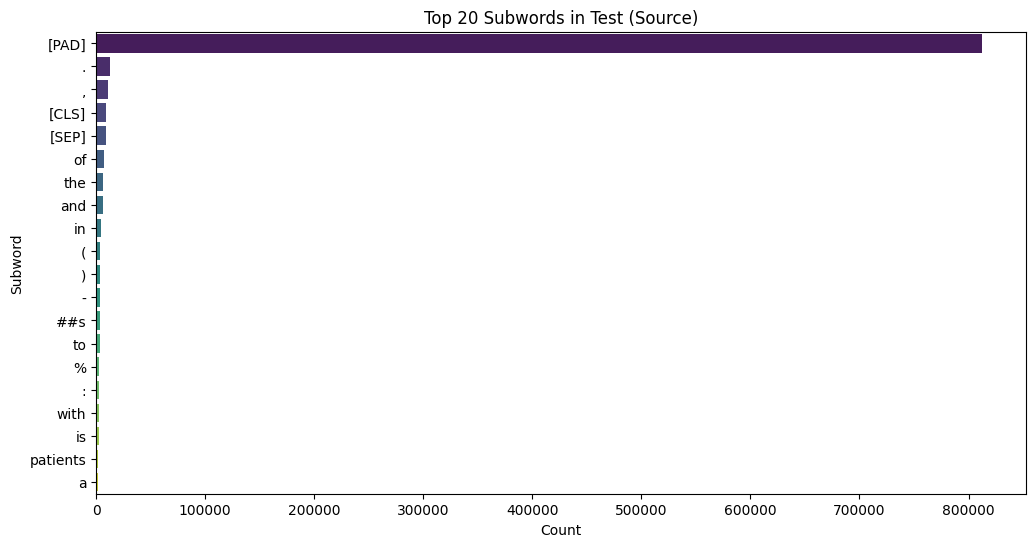

<ipython-input-110-17dd8c0c80eb>:42: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=counts, y=words, palette="viridis")


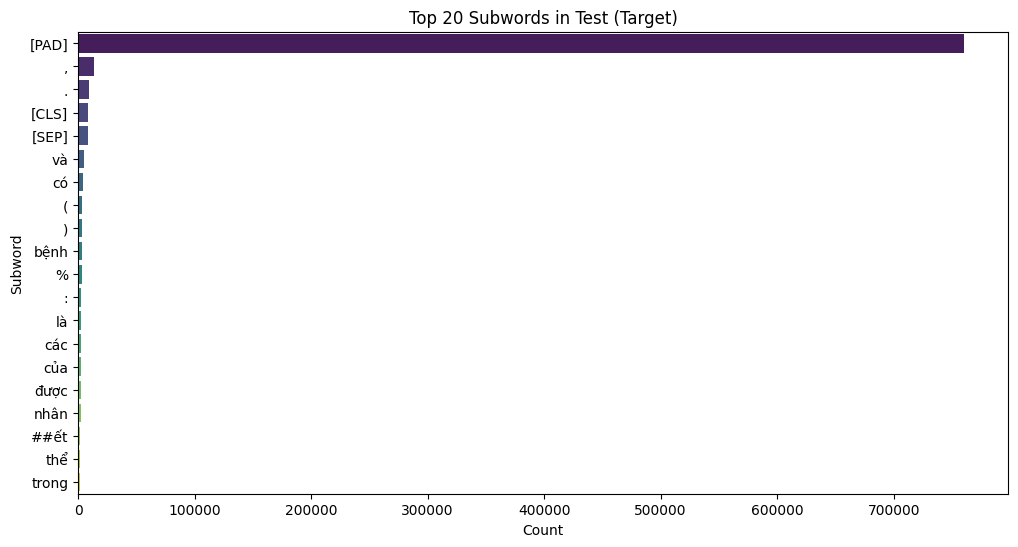

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import numpy as np

# Hàm để trích xuất và đếm các subword từ tokens_source và tokens_target
def extract_subwords(dataset, column_name):
    subwords = []
    for item in dataset[column_name]:
        subwords.extend(item)  # Thêm các subword trong từng câu
    return subwords

# Trích xuất subwords từ các cột tokens_source và tokens_target trong tập train, validation, và test
train_source_subwords = extract_subwords(tokenized_datasets['train'], 'tokens_source')
train_target_subwords = extract_subwords(tokenized_datasets['train'], 'tokens_target')

valid_source_subwords = extract_subwords(tokenized_datasets['validation'], 'tokens_source')
valid_target_subwords = extract_subwords(tokenized_datasets['validation'], 'tokens_target')

test_source_subwords = extract_subwords(tokenized_datasets['test'], 'tokens_source')
test_target_subwords = extract_subwords(tokenized_datasets['test'], 'tokens_target')

# Đếm số lần xuất hiện của các subwords
def get_top_n_subwords(subwords, n=20):
    counter = Counter(subwords)
    return counter.most_common(n)

# Lấy top 20 subwords phổ biến trong train, validation và test
train_source_top_20 = get_top_n_subwords(train_source_subwords)
train_target_top_20 = get_top_n_subwords(train_target_subwords)

valid_source_top_20 = get_top_n_subwords(valid_source_subwords)
valid_target_top_20 = get_top_n_subwords(valid_target_subwords)

test_source_top_20 = get_top_n_subwords(test_source_subwords)
test_target_top_20 = get_top_n_subwords(test_target_subwords)

# Chuyển đổi thành dạng để vẽ biểu đồ
def plot_top_subwords(top_20, title):
    words, counts = zip(*top_20)
    plt.figure(figsize=(12, 6))
    sns.barplot(x=counts, y=words, palette="viridis")
    plt.title(title)
    plt.xlabel('Count')
    plt.ylabel('Subword')
    plt.show()

# Vẽ biểu đồ cho từng tập dữ liệu
plot_top_subwords(train_source_top_20, "Top 20 Subwords in Train (Source)")
plot_top_subwords(train_target_top_20, "Top 20 Subwords in Train (Target)")

plot_top_subwords(valid_source_top_20, "Top 20 Subwords in Validation (Source)")
plot_top_subwords(valid_target_top_20, "Top 20 Subwords in Validation (Target)")

plot_top_subwords(test_source_top_20, "Top 20 Subwords in Test (Source)")
plot_top_subwords(test_target_top_20, "Top 20 Subwords in Test (Target)")


# DATA ANALYSIS (Bỏ)

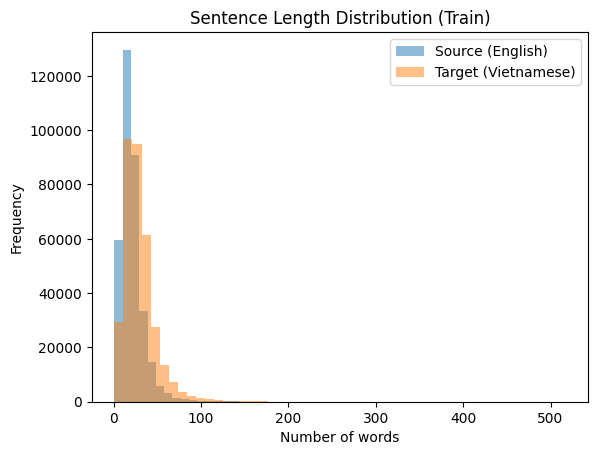

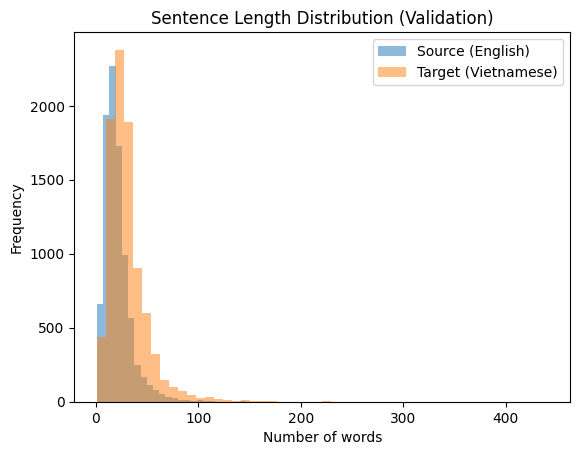

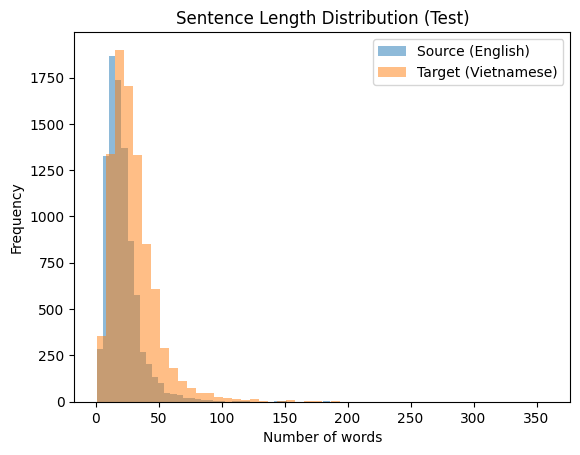

In [ ]:
# Analyze sentence lengths
def analyze_sentence_lengths(dataset, split_name):
    lengths_source = [len(text.split()) for text in dataset['source']]
    lengths_target = [len(text.split()) for text in dataset['target']]

    plt.hist(lengths_source, bins=50, alpha=0.5, label="Source (English)")
    plt.hist(lengths_target, bins=50, alpha=0.5, label="Target (Vietnamese)")
    plt.title(f"Sentence Length Distribution ({split_name})")
    plt.xlabel("Number of words")
    plt.ylabel("Frequency")
    plt.legend()
    plt.show()

# Analyze train, validation, and test
analyze_sentence_lengths(ds['train'], "Train")
analyze_sentence_lengths(ds['validation'], "Validation")
analyze_sentence_lengths(ds['test'], "Test")